In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
# from small_script.myFunctions import *
sys.path.insert(0, "/Users/weilu/openmmawsem")
from helperFunctions.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [46]:
from Bio.PDB import *

class ExtractResidues(Select):

    def __init__(self, ResidueIndexGroup, resList):
        super(ExtractResidues, self).__init__()
        self.ResidueIndexGroup = ResidueIndexGroup
        self.resList = resList

    def accept_residue(self, residue):
        if self.resList.index(residue) in self.ResidueIndexGroup:
            return True
        else:
            return False

def extractResidues(structure, toName, ResidueIndexGroup):
    resList = list(structure.get_residues())
    io = PDBIO()
    io.set_structure(structure)
    io.save(toName, ExtractResidues(ResidueIndexGroup, resList))

In [47]:
def getFrame(frame, outLocation, movieLocation="movie.pdb"):
    location = movieLocation
    with open(location) as f:
        a = f.readlines()
    n = len(a)
    # get the position of every model title
    model_title_index_list = []
    for i in range(n):
        if len(a[i]) >= 5 and a[i][:5] == "MODEL":
            model_title_index = i
            model_title_index_list.append(model_title_index)
    model_title_index_list.append(n)
    check_array = np.diff(model_title_index_list)
    if np.allclose(check_array, check_array[0]):
        size = check_array[0]
    elif np.allclose(check_array[:-1], check_array[0]) and check_array[-1] == check_array[0] + 1:
        # this is ok. with extra "END"
        size = check_array[0]
    else:  
        print("!!!! Someting is wrong  !!!!")
        print(check_array)
    with open(outLocation, "w") as out:
        out.write("".join(a[size*frame:size*(frame+1)]))


def get_two_part_from_eye_seperation(pdb, data):
    row = data.query(f"Protein == '{pdb}'")
    assert len(row) == 1
    row = row.iloc[0]
    glob_start, glob_end = row["Range"].split("-")
    length = row["Length"]
    glob_start = int(glob_start)
    glob_end = int(glob_end)
    print(pdb, glob_start, glob_end)
    GlobularPart = list(range(glob_start, glob_end+1))
    MembranePart = []
    for i in range(1, length+1):
        if i not in GlobularPart:
            MembranePart.append(i)
    return GlobularPart, MembranePart



In [3]:
pdb_list = ["2bg9", "1j4n", "1py6_SD", "2bl2", "1rhz", "1iwg", "2ic8", "1pv6", "1occ", "1kpl", "2bs2", "1py6", "1u19"]

In [5]:
pre = "/Users/weilu/Research/server/oct_2019/dataset_membrane"
line = getFromTerminal(f"wc {pre}/setups/1iwg/ssweight")

In [11]:
length = line.split()[0]

In [13]:
a_ = []
for pdb in pdb_list:
    pre = "/Users/weilu/Research/server/oct_2019/dataset_membrane"
    line = getFromTerminal(f"wc {pre}/setups/{pdb}/ssweight")
    length = line.split()[0]
    a_.append([pdb, length])

In [37]:
d = pd.DataFrame(a_, columns=["Protein", "Length"])

In [17]:
d.to_csv("/Users/weilu/Research/database/prediction_membrane.csv")

In [38]:
d

Protein Length
0      2bg9     91
1      1j4n    116
2   1py6_SD    123
3      2bl2    145
4      1rhz    166
5      1iwg    168
6      2ic8    182
7      1pv6    190
8      1occ    191
9      1kpl    203
10     2bs2    217
11     1py6    227
12     1u19    278

In [26]:
simulationType = "membrane_protein_simulation"
# folder = "original"
# folder = "first"
# folder = "second_withoutExclusion"
# folder_list = ["first", "second_withoutExclusion"]
folder_list = ["trial_1_cutoff100_burial_off", "original_water_gamma_burial_off", 
              "trial_1_cutoff300_burial_off", "kim_gamma_burial_off"]
n = 3
all_data = []
for folder in folder_list:
    for pdb in pdb_list:
        for i in range(n):
                pre = f"/Users/weilu/Research/server/oct_2019/dataset_membrane/{folder}/{pdb}/{i}"
#                 if folder == "third":
#                     info_file = "info_recompute.dat"
#                 else:
                info_file = "info.dat"
                location = f"{pre}/{info_file}"
                try:
                    tmp = pd.read_csv(location, sep="\s+")
                    tmp = tmp.assign(Run=i, Protein=pdb, Folder=folder)
                    all_data.append(tmp)
                except:
                    print(pdb, i, folder)
                    pass
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)

2bl2 2 trial_1_cutoff300_burial_off
1rhz 0 trial_1_cutoff300_burial_off
1rhz 1 trial_1_cutoff300_burial_off
1rhz 2 trial_1_cutoff300_burial_off
1u19 0 kim_gamma_burial_off
1u19 1 kim_gamma_burial_off
1u19 2 kim_gamma_burial_off
/Users/weilu/Research/data/openMM/membrane_protein_simulation_10-19.csv


In [39]:
d = data.query("Steps > 1000")

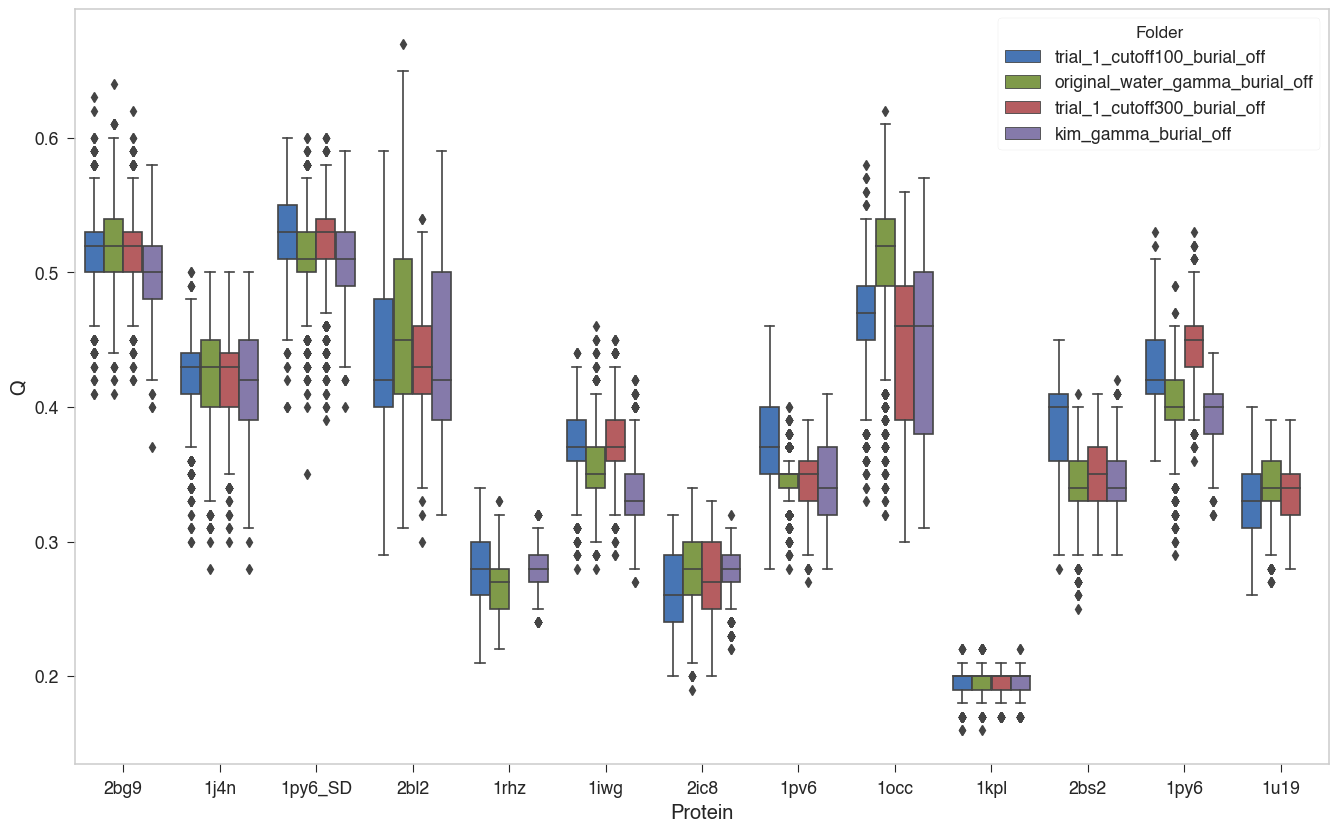

In [40]:
sns.boxplot("Protein", "Q", hue="Folder", data=d)

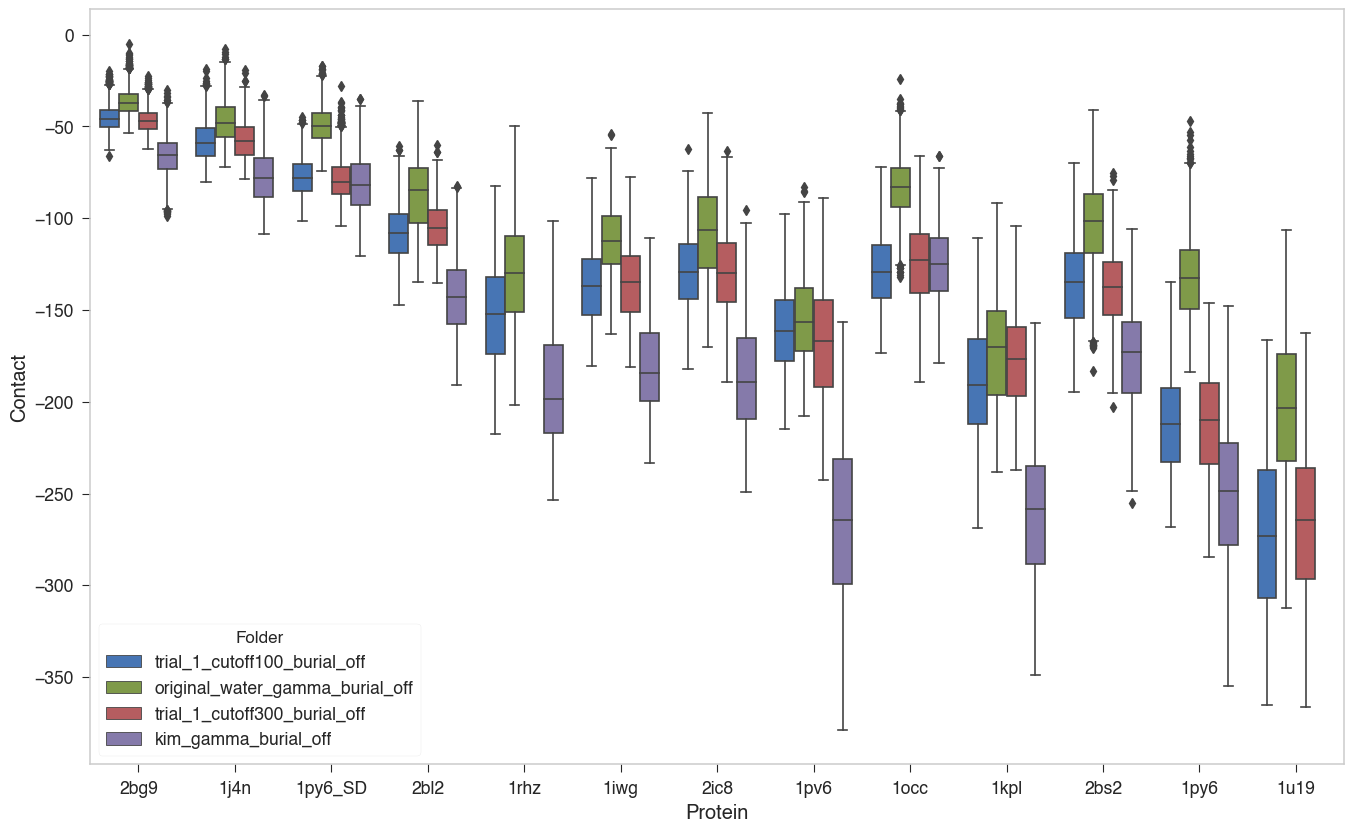

In [36]:
sns.boxplot("Protein", "Contact", hue="Folder", data=d)

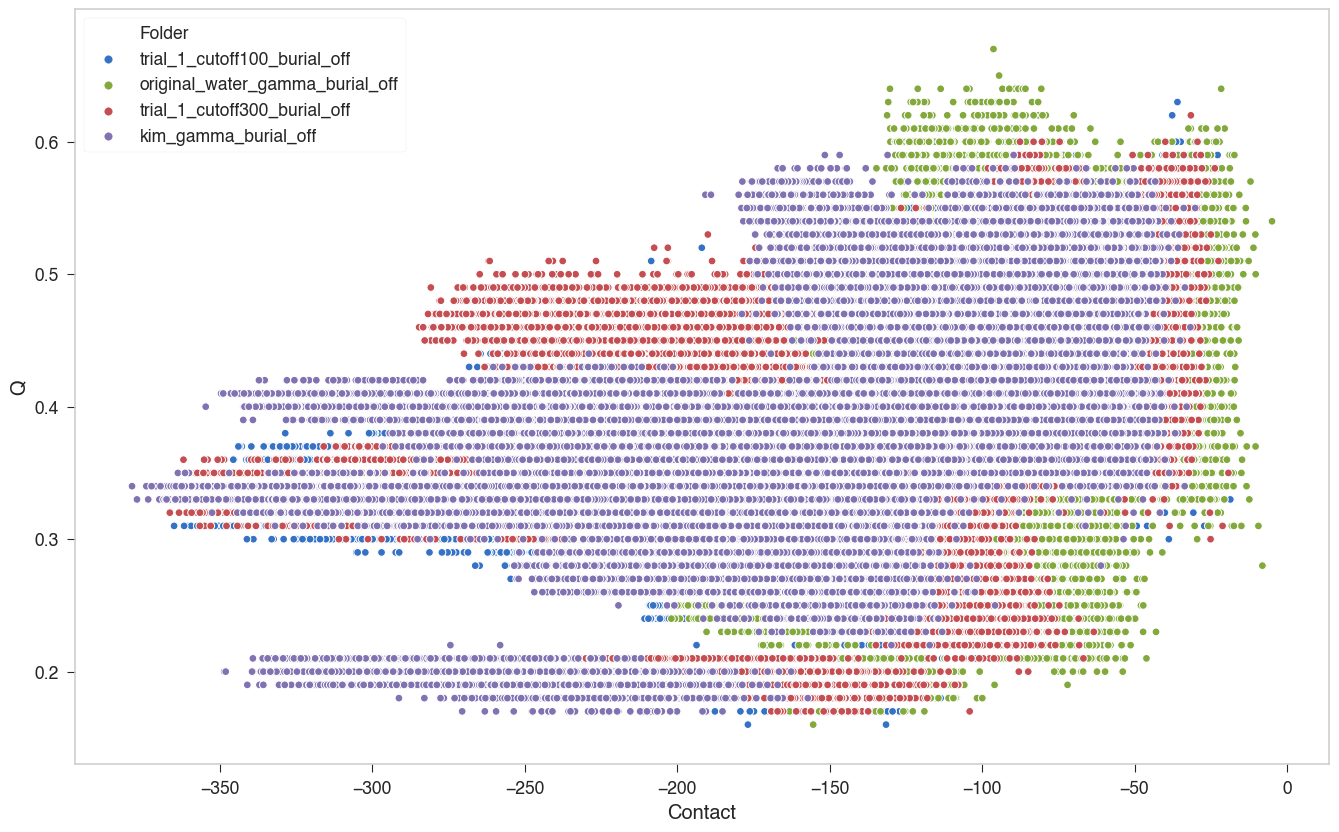

In [35]:
sns.scatterplot("Contact", "Q", hue="Folder", data=d)

In [34]:
d.columns

Index(['Steps', 'Q', 'Rg', 'Backbone', 'Rama', 'Contact', 'Fragment',
       'Membrane', 'ER', 'TBM_Q', 'Beta', 'Pap', 'Helical', 'Total', 'Run',
       'Protein', 'Folder'],
      dtype='object')

In [ ]:
# length_info = pd.read_csv("/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/length_info.csv", index_col=0)
length_info = pd.read_csv("/Users/weilu/Research/database/hybrid_prediction_database/length_info.csv", index_col=0)

length_info = length_info.sort_values("Length").reset_index()
pdb_list_sorted_by_length = list(length_info.Protein.unique())
length_info_sorted_by_length = list(length_info.Length.unique())
label_list = []
for p, n in zip(pdb_list_sorted_by_length, length_info_sorted_by_length):
    label_list.append(p+f"\n{n}")

In [48]:
pdb_list =['4a2n', '3kp9', '5xpd', '2xov_complete', '5d91', '6e67A']
# pdb_list = ["2xov_complete", "6e67A", "5xpd", "3kp9", "4a2n", "5d91", "2jo1"]
pdb_list = ["2xov_complete", "6e67A", "5xpd", "3kp9", "4a2n", "5d91", "4nv6", "4p79", "5dsg", "6g7o", "6a93", "2jo1", "1py6", "1pv6", "1u19"]



In [49]:
# length_info = pd.read_csv("/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/length_info.csv", index_col=0)
length_info = pd.read_csv("/Users/weilu/Research/database/hybrid_prediction_database/length_info.csv", index_col=0)

length_info = length_info.sort_values("Length").reset_index()
pdb_list_sorted_by_length = list(length_info.Protein.unique())
length_info_sorted_by_length = list(length_info.Length.unique())
label_list = []
for p, n in zip(pdb_list_sorted_by_length, length_info_sorted_by_length):
    label_list.append(p+f"\n{n}")

In [70]:
pd.set_option('max_colwidth', 100)

In [71]:
length_info[["Protein", "Length", "Name"]]

Protein  Length  \
0            2jo1      72   
1            4p79     181   
2            4a2n     192   
3            1py6     227   
4            3kp9     259   
5            4nv6     264   
6            5xpd     269   
7   2xov_complete     276   
8            5d91     335   
9            1u19     348   
10           6g7o     350   
11           6a93     370   
12           5dsg     392   
13           1pv6     417   
14          6e67A     457   

                                                                            Name  
0              Structure of the Na K-ATPase regulatory protein FXYD1 in micelles  
1                                                               mouse claudin-15  
2                                                                        Ma-ICMT  
3                                    Bacteriorhodopsin crystallized from bicells  
4                               bacterial homolog of vitamin K epoxide reductase  
5                                      intramembrane vitamin K epoxide reductase  
6                                                 Sugar transporter of AtSWEET13  
7                                                                            NaN  
8   phosphatidylinositolphosphate (PIP) synthase from Renibacterium Salmoninarum  
9                                                               Bovine Rhodopsin  
10                                           human alkaline ceramidase 3 (ACER3)  
11                                           5-HT2AR in complex with risperidone  
12                                M4 muscarinic acetylcholine receptor (M4-mT4L)  
13                                                              lactose permease  
14                               beta2 adrenergic receptor fused to a Gs peptide

In [72]:
simulationType = "hybrid_protein_simulation"
# folder = "original"
# folder = "first"
# folder = "second_withoutExclusion"
# folder_list = ["first", "second_withoutExclusion"]
folder_list = ["third", "fourth", "fifth", "firth", "sixth"]
all_data = []
for folder in folder_list:
    for pdb in pdb_list:
        for i in range(20):
                pre = f"/Users/weilu/Research/server/aug_2019/{simulationType}/{folder}/{pdb}/{i}"
                if folder == "third":
                    info_file = "info_recompute.dat"
                else:
                    info_file = "info.dat"
                location = f"{pre}/{info_file}"
                try:
                    tmp = pd.read_csv(location, sep="\s+")
                    tmp = tmp.assign(Run=i, Protein=pdb, Folder=folder)
                    all_data.append(tmp)
                except:
                    print(pdb, i, folder)
                    pass
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)

1pv6 3 fourth
1pv6 5 fourth
1pv6 10 fourth
1pv6 14 fourth
1pv6 18 fourth
2xov_complete 10 sixth
2xov_complete 11 sixth
2xov_complete 12 sixth
2xov_complete 13 sixth
2xov_complete 14 sixth
2xov_complete 15 sixth
2xov_complete 16 sixth
2xov_complete 17 sixth
2xov_complete 18 sixth
2xov_complete 19 sixth
6e67A 10 sixth
6e67A 11 sixth
6e67A 12 sixth
6e67A 13 sixth
6e67A 14 sixth
6e67A 15 sixth
6e67A 16 sixth
6e67A 17 sixth
6e67A 18 sixth
6e67A 19 sixth
5xpd 10 sixth
5xpd 11 sixth
5xpd 12 sixth
5xpd 13 sixth
5xpd 14 sixth
5xpd 15 sixth
5xpd 16 sixth
5xpd 17 sixth
5xpd 18 sixth
5xpd 19 sixth
3kp9 10 sixth
3kp9 11 sixth
3kp9 12 sixth
3kp9 13 sixth
3kp9 14 sixth
3kp9 15 sixth
3kp9 16 sixth
3kp9 17 sixth
3kp9 18 sixth
3kp9 19 sixth
4a2n 10 sixth
4a2n 11 sixth
4a2n 12 sixth
4a2n 13 sixth
4a2n 14 sixth
4a2n 15 sixth
4a2n 16 sixth
4a2n 17 sixth
4a2n 18 sixth
4a2n 19 sixth
5d91 10 sixth
5d91 11 sixth
5d91 12 sixth
5d91 13 sixth
5d91 14 sixth
5d91 15 sixth
5d91 16 sixth
5d91 17 sixth
5d91 18 sixth
5

In [74]:
data = pd.read_csv("/Users/weilu/Research/data/openMM/hybrid_protein_simulation_sixth_08-21.csv", index_col=0)

/Users/weilu/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [81]:
data.shape

(2692690, 24)

In [17]:
small = data.query("Steps % 100 == 0")

In [76]:
# create label
sub_label_list = []
pdb_list_sorted_by_length = ['2jo1', '4p79', '4a2n', '1py6', '3kp9', '4nv6', '5xpd', '2xov', '5d91', '1u19', '6g7o', '6a93', '5dsg', '1pv6', '6e67A']
length_info_sorted_by_length = length_info["Length"].tolist()
sub_label_list = []
for p, n in zip(pdb_list_sorted_by_length, length_info_sorted_by_length):
    sub_label_list.append(p+f"\n{n}")

In [77]:
sub_pdb_list = length_info["Protein"].tolist()
data.Protein = pd.Categorical(data.Protein, 
                      categories=sub_pdb_list)

In [78]:
convert_dic = {"firth":"hybrid contact", "third":"HE",
              "fourth":"contact as in water", "fifth":"no contact", "sixth":"contact as in membrane"}
max_Q_mem_data["Scheme"] = max_Q_mem_data["Folder"].apply(lambda x: convert_dic[x])

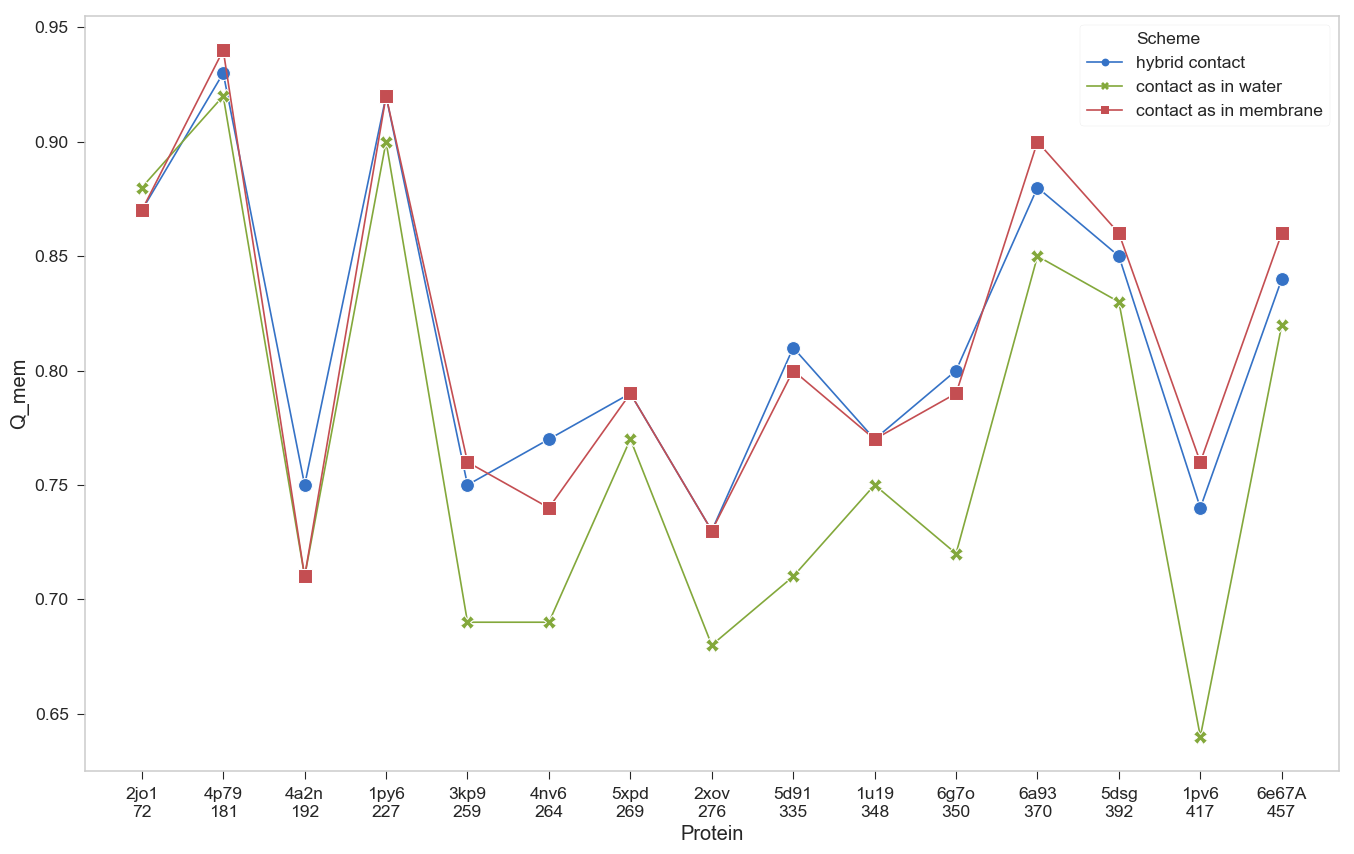

In [79]:
y = "Q_mem"
d = data.query("Steps > 200").reset_index(drop=True)

t = d.groupby(["Protein", "Folder"])[y].idxmax().reset_index()
max_Q_mem_data = d.iloc[t[y].to_list()].reset_index(drop=True)
max_Q_mem_data["Scheme"] = max_Q_mem_data["Folder"].apply(lambda x: convert_dic[x])
sub_data = max_Q_mem_data.query("Scheme in ['hybrid contact', 'contact as in water', 'contact as in membrane']")
# sub_data = max_Q_mem_data
ax = sns.lineplot(x="Protein", y=y, markers=True, ms=10, style="Scheme", hue="Scheme", data=sub_data, dashes=False)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')


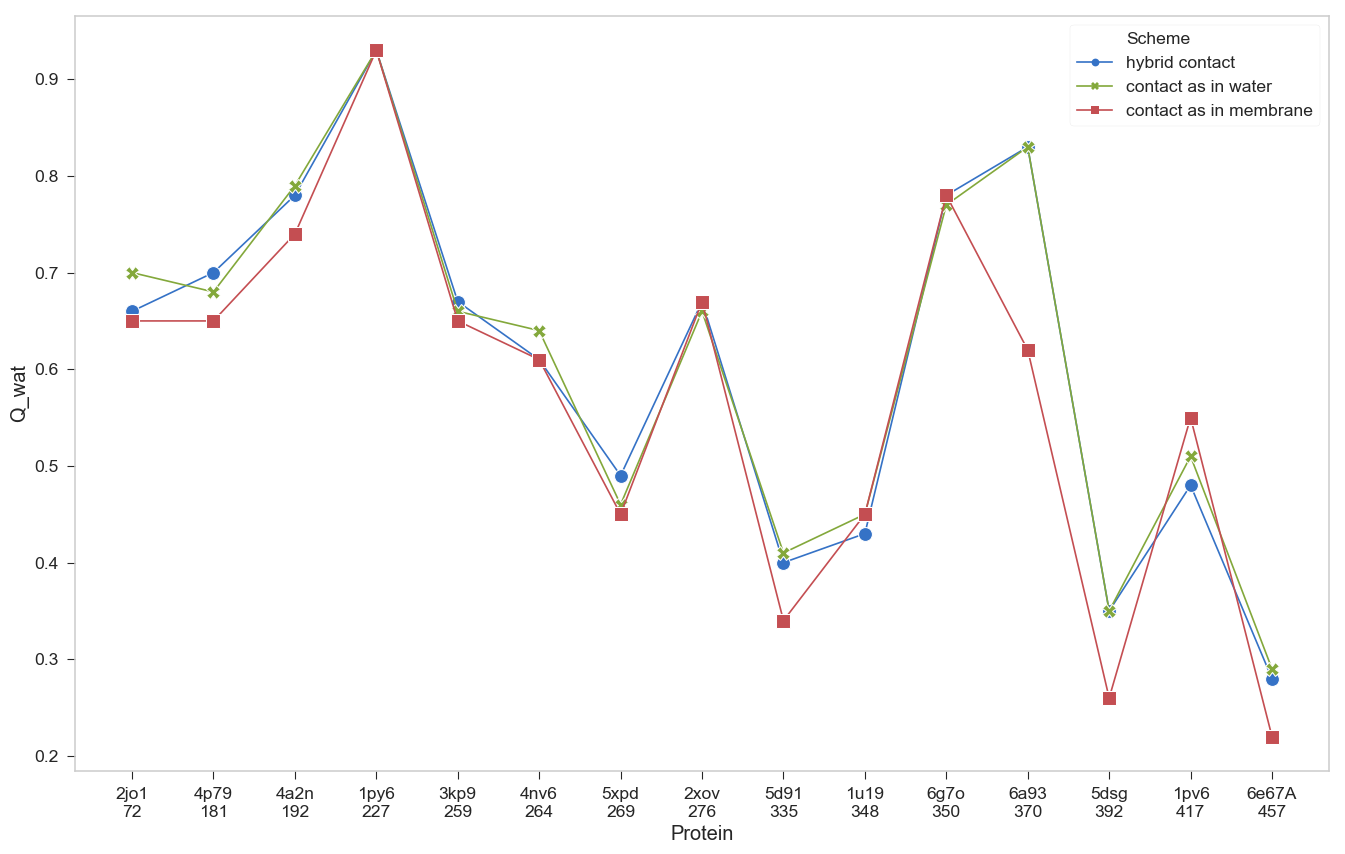

In [80]:
y = "Q_wat"
d = data.query("Steps > 200").reset_index(drop=True)

t = d.groupby(["Protein", "Folder"])[y].idxmax().reset_index()
max_Q_mem_data = d.iloc[t[y].to_list()].reset_index(drop=True)
max_Q_mem_data["Scheme"] = max_Q_mem_data["Folder"].apply(lambda x: convert_dic[x])
sub_data = max_Q_mem_data.query("Scheme in ['hybrid contact', 'contact as in water', 'contact as in membrane']")
ax = sns.lineplot(x="Protein", y=y, markers=True, ms=10, style="Scheme", hue="Scheme", data=sub_data, dashes=False)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')


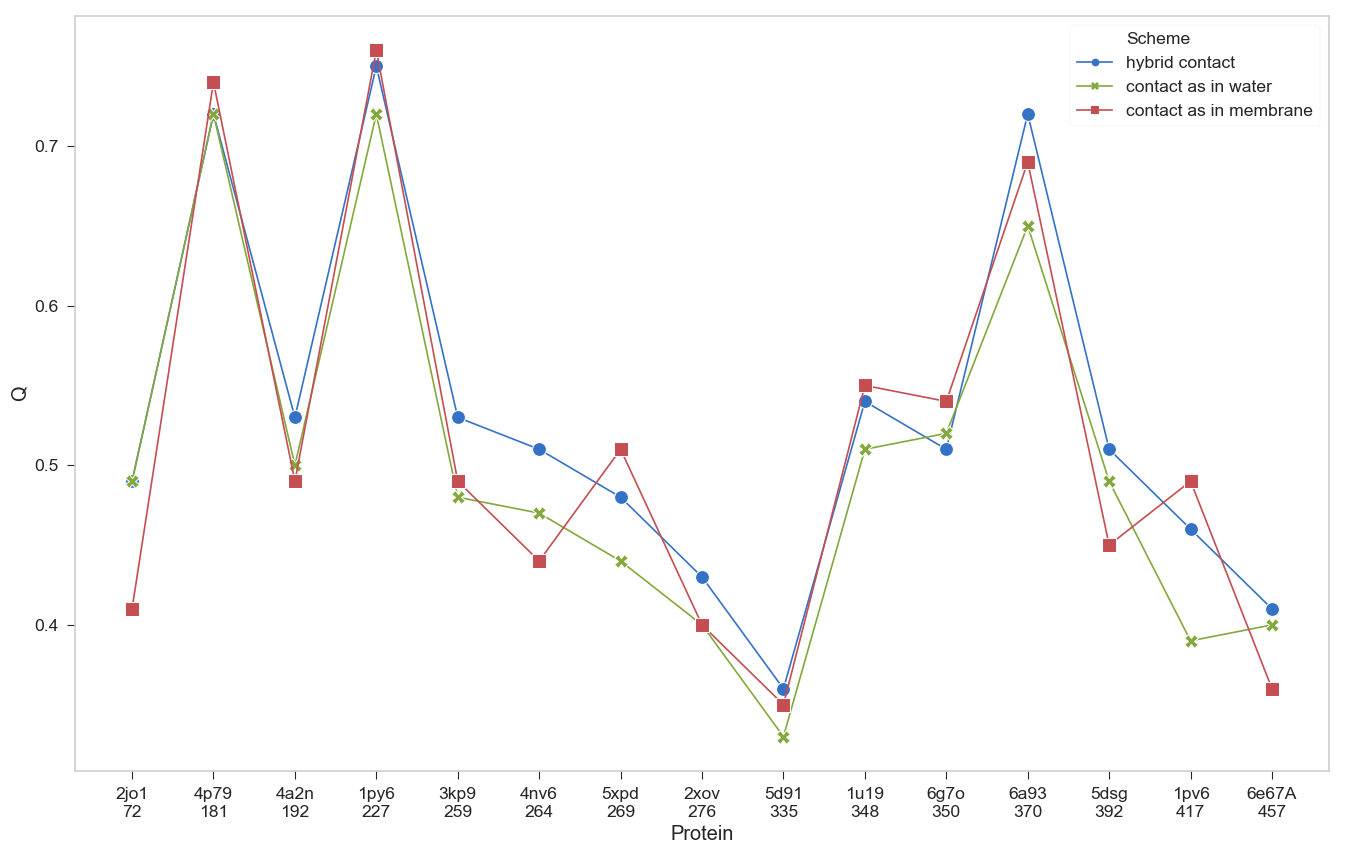

In [83]:
y = "Q"
d = data.query("Steps > 200").reset_index(drop=True)

t = d.groupby(["Protein", "Folder"])[y].idxmax().reset_index()
max_Q_mem_data = d.iloc[t[y].to_list()].reset_index(drop=True)
max_Q_mem_data["Scheme"] = max_Q_mem_data["Folder"].apply(lambda x: convert_dic[x])
sub_data = max_Q_mem_data.query("Scheme in ['hybrid contact', 'contact as in water', 'contact as in membrane']")
# sub_data = max_Q_mem_data
ax = sns.lineplot(x="Protein", y=y, markers=True, ms=10, style="Scheme", hue="Scheme", data=sub_data, dashes=False)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')


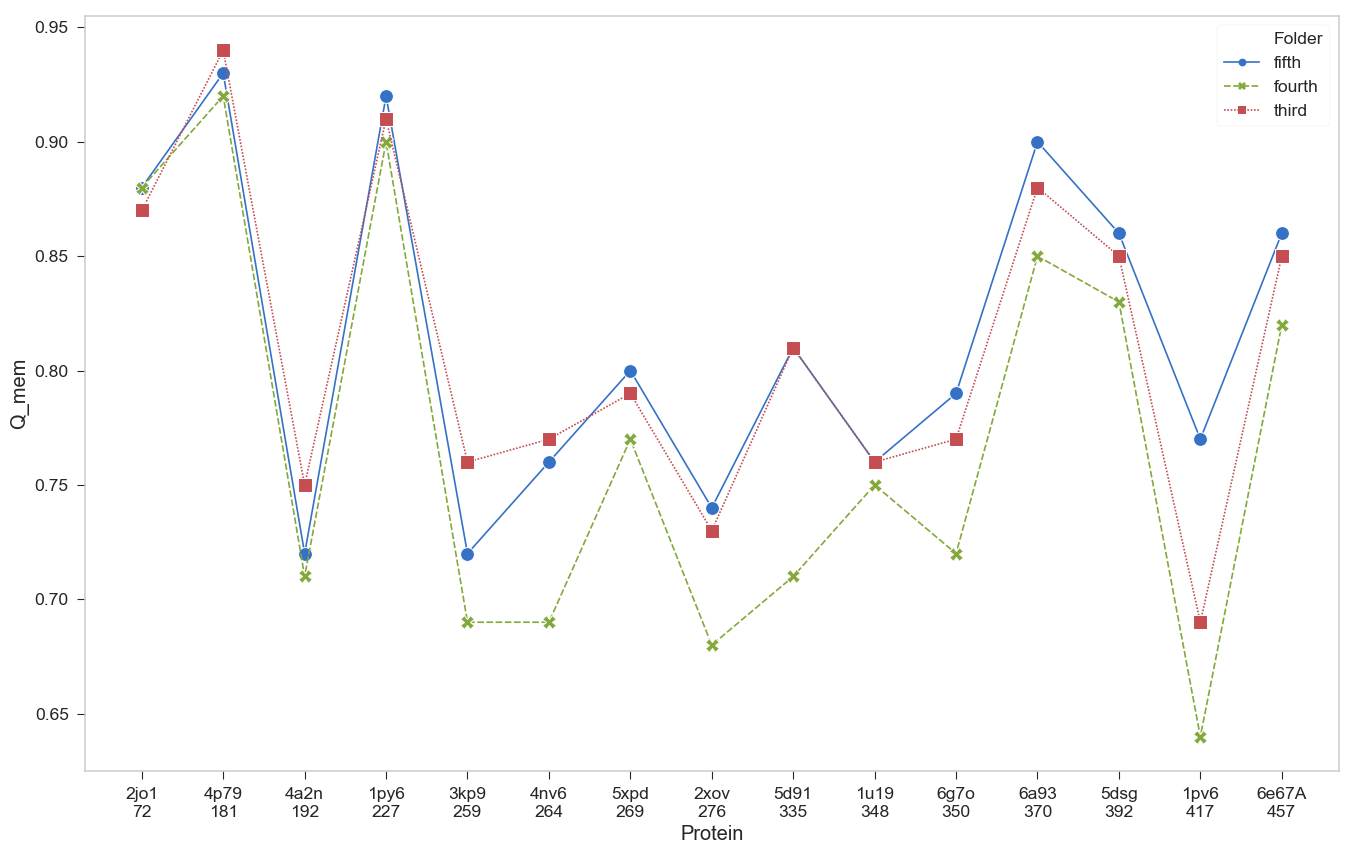

In [26]:
y = "Q_mem"
d = data.query("Steps > 200").reset_index(drop=True)

t = d.groupby(["Protein", "Folder"])[y].idxmax().reset_index()
max_Q_mem_data = d.iloc[t[y].to_list()].reset_index(drop=True)

ax = sns.lineplot(x="Protein", y=y, markers=True, ms=10, style="Folder", hue="Folder", data=max_Q_mem_data)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')


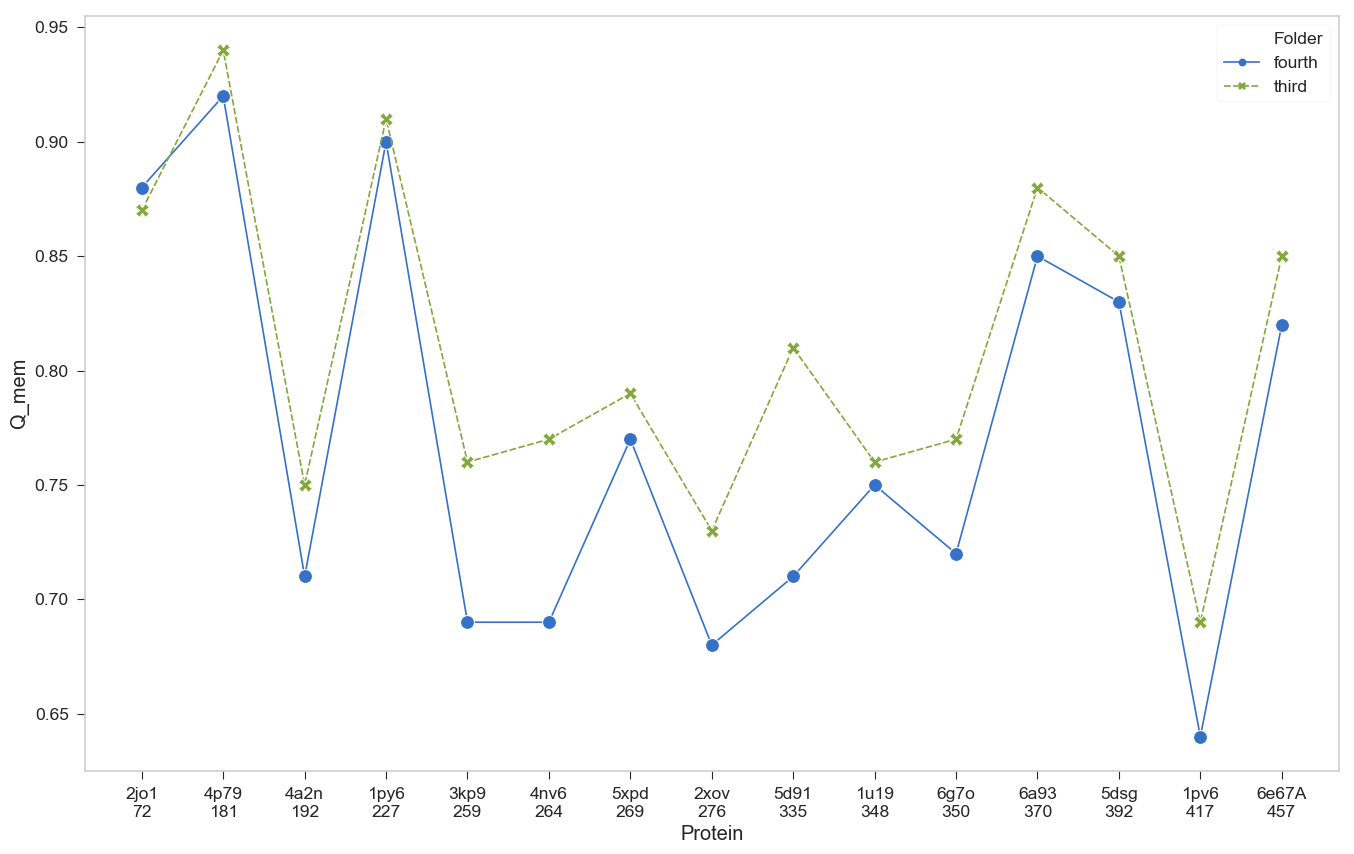

In [18]:
y = "Q_mem"
d = data.query("Steps > 200").reset_index(drop=True)

t = d.groupby(["Protein", "Folder"])[y].idxmax().reset_index()
max_Q_mem_data = d.iloc[t[y].to_list()].reset_index(drop=True)

ax = sns.lineplot(x="Protein", y=y, markers=True, ms=10, style="Folder", hue="Folder", data=max_Q_mem_data)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')


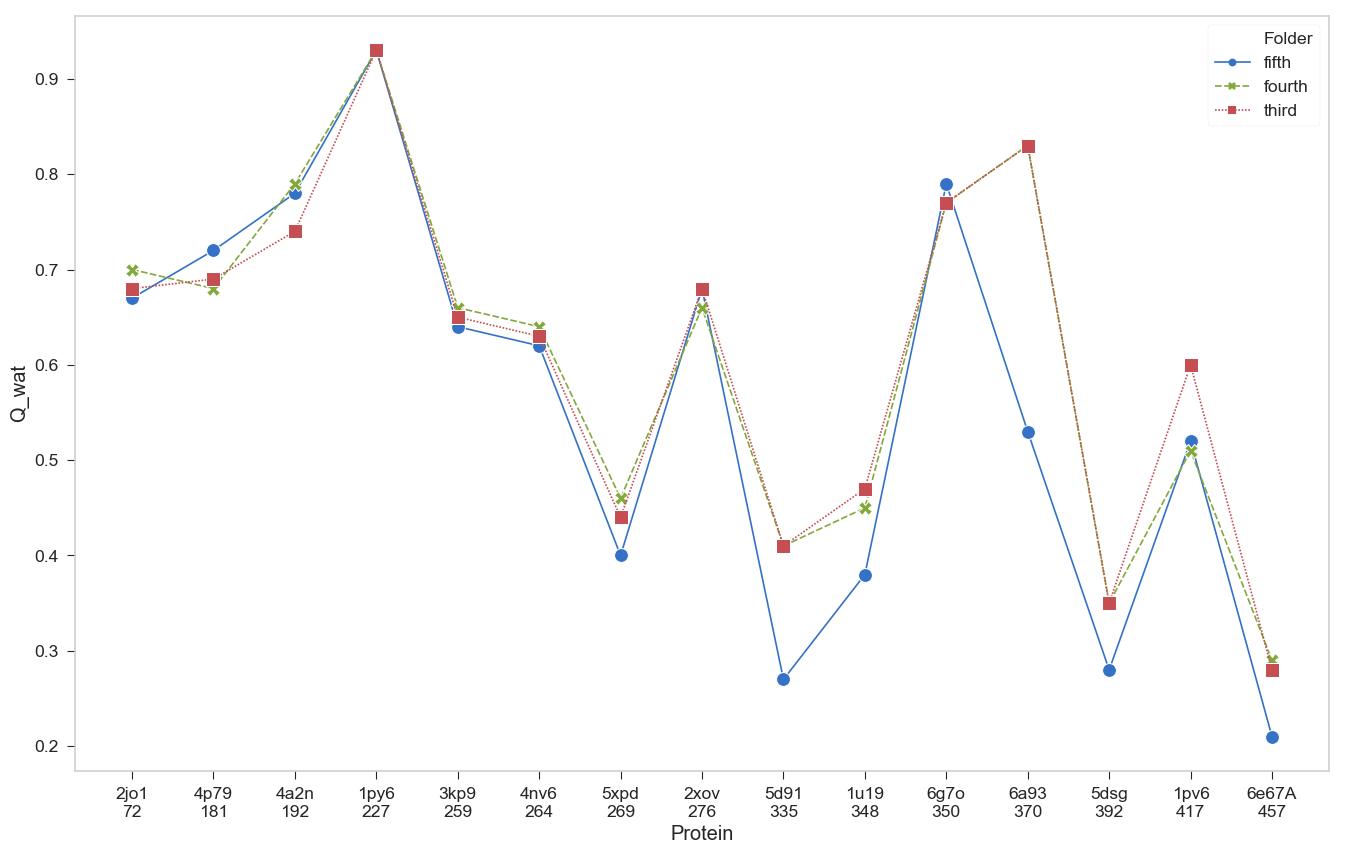

In [28]:
y = "Q_wat"
d = data.query("Steps > 200").reset_index(drop=True)

t = d.groupby(["Protein", "Folder"])[y].idxmax().reset_index()
max_Q_wat_data = d.iloc[t[y].to_list()].reset_index(drop=True)
# , style="Frag"
ax = sns.lineplot(x="Protein", y=y, markers=True, ms=10, style="Folder", hue="Folder", data=max_Q_wat_data)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')


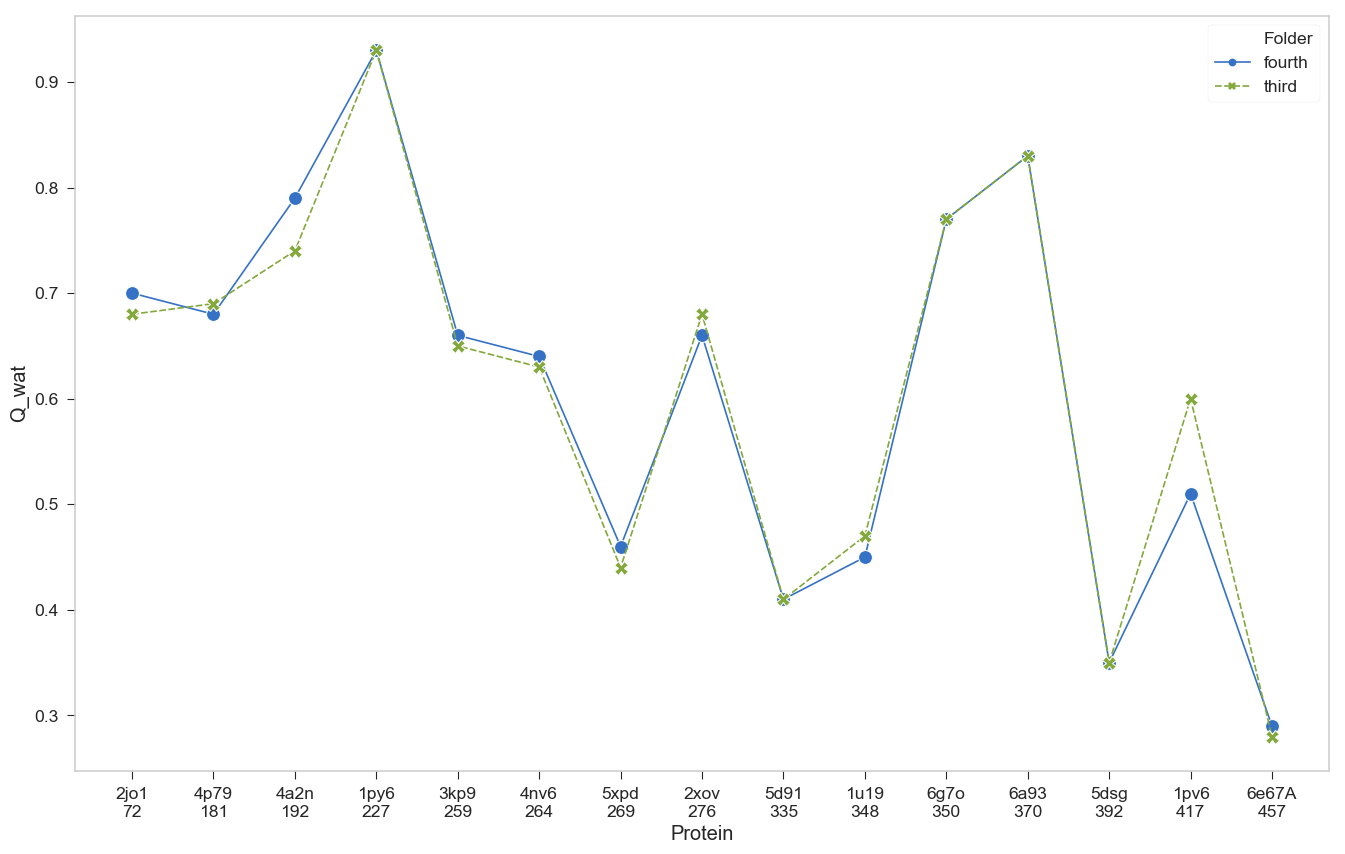

In [20]:
y = "Q_wat"
d = data.query("Steps > 200").reset_index(drop=True)

t = d.groupby(["Protein", "Folder"])[y].idxmax().reset_index()
max_Q_wat_data = d.iloc[t[y].to_list()].reset_index(drop=True)
# , style="Frag"
ax = sns.lineplot(x="Protein", y=y, markers=True, ms=10, style="Folder", hue="Folder", data=max_Q_wat_data)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')


In [33]:
def flip_side(side):
#     return side * -1
    if side == "down":
        return "up"
    if side == "up":
        return "down"
def get_PredictedZimWithSide(pdb):
    pre = "/Users/weilu/Research/server/aug_2019/second_hybrid_protein_simulation/"
    loc = f"{pre}/TM_pred/{pdb}_topo"
    with open(loc) as f:
        a = f.readlines()
    assert len(a) % 3 == 0
    chain_count = len(a) // 3
    seq = ""
    for i in range(chain_count):
        seq_i = (a[i*3+2]).strip()
        seq += seq_i
    assert np.alltrue([i in ["0", "1"] for i in seq])

    side = "down"
    with open(f"{pre}/TM_pred/zims/{pdb}_predicted_zim", "w") as out:
        for i in seq:
            if i == "0":
                out.write(f"{side}\n")
                inMiddle = False
            elif i == "1":
                out.write("middle\n")
                if not inMiddle:
                    side = flip_side(side)
                    inMiddle = True
            else:
                raise


In [34]:
for pdb in pdb_list:
    get_PredictedZimWithSide(pdb)

In [35]:
for pdb in pdb_list:
    cmd = f"cp /Users/weilu/Research/server/aug_2019/second_hybrid_protein_simulation/TM_pred/zims/{pdb}_predicted_zim /Users/weilu/Research/server/aug_2019/second_hybrid_protein_simulation/setup/{pdb}/PredictedZimSide"
    os.system(cmd)

In [26]:
pdb = "1pv6"
pre = "/Users/weilu/Research/server/aug_2019/second_hybrid_protein_simulation/"
loc = f"{pre}/TM_pred/{pdb}_topo"
with open(loc) as f:
    a = f.readlines()
assert len(a) % 3 == 0
chain_count = len(a) // 3
seq = ""
for i in range(chain_count):
    seq_i = (a[i*3+2]).strip()
    seq += seq_i
assert np.alltrue([i in ["0", "1"] for i in seq])

side = "down"
with open(f"{pre}/TM_pred/zims/{pdb}_predicted_zim", "w") as out:
    for i in seq:
        if i == "0":
            o = side
            out.write(f"{side}\n")
            inMiddle = False
        elif i == "1":
            o = "middle"
            out.write("middle\n")
            if not inMiddle:
                side = flip_side(side)
                inMiddle = True
        else:
            raise
        print(i, o)

0 down
0 down
0 down
0 down
0 down
0 down
0 down
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
0 up
0 up
0 up
0 up
0 up
0 up
0 up
0 up
0 up
0 up
0 up
0 up
0 up
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
0 down
0 down
0 down
0 down
0 down
0 down
0 down
0 down
0 down
0 down
0 down
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
0 up
0 up
0 up
0 up
0 up
0 up
0 up
0 up
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
1 middle
0 down
0 down
0 down
0

In [36]:
seq

'000000011111111111111111111111111000000000000011111111111111111100000000000111111111111111111110000000011111111111111111110000000000000000000111111111111111111100000000001111111111111100000000000000000000000000000000000000111111111111111111000000000000000000000111111111111111111111000000001111111111111111100000000000011111111111111100000000000011111111111111111111111000000000001111111111111111110000000000000000000'

In [43]:
# those in membrane form groups
def fromTopSeqToGALL(seq):
    res_list = []
    first = None
    count = 1
    previousEnd = 0
    # print("g_all = [")
    out = "[\n"
    for i, res in enumerate(seq):
        if res == "0":
            if len(res_list) > 0:
                # print(f"g{count} =", res_list)
                print(res_list, ", ")
                out += f"    {res_list},\n"
                count += 1
                last = res_list[-1]
                first = res_list[0] if first is None else first
                span = res_list[0] - previousEnd
                previousEnd = last
            res_list = []
        if res == "1":
            res_list.append(i)
    out += "]\n"
    return out

In [41]:
out

'[\n    [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],\n    [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63],\n    [75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94],\n    [103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121],\n    [141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159],\n    [170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183],\n    [222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239],\n    [261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281],\n    [290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306],\n    [319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333],\n    [346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356

In [29]:
pdb = "1pv6"
with open(f"{pre}/TM_pred/zims/{pdb}_predicted_zim") as f:
    a = f.readlines()

In [30]:
infoLocation = "/Users/weilu/Research/database/hybrid_prediction_database/length_info.csv"
info = pd.read_csv(infoLocation, index_col=0)
# get_two_part_from_eye
part_info = pd.read_csv("/Users/weilu/Research/database/hybrid_prediction_database/part_info.csv", names=["Protein", "Range"])
part_info = part_info.merge(info, on="Protein")

In [37]:
pdb = "2jo1"
run = 0
step = 10
outLocation = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/best_Q_structures/{pdb}_best.pdb"
movieLocation = f'/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/{pdb}/{run}/movie.pdb'
frame = step - 2
def get_best_frame_and_extract(pdb, run, frame, outLocation, movieLocation):
    getFrame(frame, outLocation, movieLocation)
    GlobularPart, MembranePart = get_two_part_from_eye_seperation(pdb, part_info)
    fileLocation = outLocation.split(".")[0]
    parser = PDBParser()
    structure = parser.get_structure('X', outLocation)
    extractResidues(structure, f"{fileLocation}_globular.pdb", GlobularPart)
    extractResidues(structure, f"{fileLocation}_membrane.pdb", MembranePart)

In [42]:
max_Q_mem_data

Steps     Q    Qc  Q_wat  Q_mem     Rg  Pulling      Con   Chain     Chi  \
0    1975  0.45  0.62   0.30   0.87  21.65      0.0    53.30   41.89    9.93   
1    1564  0.70  0.86   0.44   0.94  19.82      0.0   232.05  180.89   57.70   
2    1585  0.53  0.74   0.50   0.75  17.63      0.0   276.92  185.35   57.72   
3    1011  0.72  0.89   0.76   0.91  18.27      0.0   449.72  320.05  106.78   
4    1022  0.38  0.55   0.57   0.76  25.76      0.0   600.19  402.08  115.36   
5     573  0.33  0.46   0.50   0.77  31.47      0.0   769.80  499.82  135.10   
6     877  0.39  0.55   0.29   0.79  20.77      0.0   661.66  420.16  127.78   
7    1178  0.39  0.58   0.55   0.73  30.51      0.0   536.10  350.47   98.17   
8     894  0.33  0.49   0.26   0.81  26.21      0.0   803.92  529.71  172.93   
9     940  0.51  0.71   0.32   0.76  23.68      0.0   776.24  503.22  149.63   
10   1006  0.40  0.58   0.63   0.77  28.29      0.0   757.51  518.39  141.62   
11   1584  0.61  0.82   0.59   0.88  27.76      0.0   504.59  349.37   86.11   
12    870  0.45  0.63   0.26   0.85  26.94      0.0   980.57  660.84  201.96   
13    826  0.43  0.67   0.28   0.69  21.14      0.0  1112.74  670.64  186.57   
14    913  0.35  0.52   0.21   0.85  30.03      0.0  1013.54  689.37  193.51   

    ...  Fragment  Membrane       ER   Beta    Pap  Rg_Bias    Total  Run  \
0   ...   -266.60   -102.99     0.00 -28.27  -5.95     1.55  -798.14   13   
1   ...   -666.62   -416.37  -636.40 -66.99 -28.99    12.06 -2873.21    2   
2   ...   -785.95   -433.92  -599.63 -27.39  -0.80    12.62 -2794.08    2   
3   ...   -859.33   -651.75 -1056.87 -20.97  -6.88    10.21 -3698.55    1   
4   ...  -1093.51   -483.90  -897.77 -37.04 -12.60    10.34 -3111.15    3   
5   ...  -1060.09   -473.82  -909.17 -14.39 -11.29    11.85 -2787.14   17   
6   ...  -1011.78   -642.48 -1216.32  -6.10  -0.01    15.56 -3642.59    8   
7   ...  -1152.16   -491.70 -1312.97 -45.24 -21.13    20.14 -3743.44    6   
8   ...  -1529.79   -484.38 -1203.44 -48.18 -22.04    22.39 -4254.66    3   
9   ...  -1281.26   -718.27 -1441.99  -2.18  -4.83    19.83 -4544.33    0   
10  ...  -1526.85   -668.43 -1073.80  -9.75  -7.84    23.14 -4698.26    2   
11  ...  -1779.83   -726.59 -1677.54 -19.43  -7.19    19.46 -6906.14    2   
12  ...  -1633.80   -799.50 -1584.14  -0.87  -0.00    23.37 -5516.04    0   
13  ...  -1648.18  -1081.44 -2226.14 -25.58  -2.76    32.12 -5634.77    1   
14  ...  -1961.55   -727.23 -1483.55 -22.83 -10.00    16.36 -6187.35    5   

          Protein  Folder  
0            2jo1   third  
1            4p79   third  
2            4a2n   third  
3            1py6   third  
4            3kp9   third  
5            4nv6   third  
6            5xpd   third  
7   2xov_complete   third  
8            5d91   third  
9            1u19   third  
10           6g7o   third  
11           6a93   third  
12           5dsg   third  
13           1pv6   third  
14          6e67A   third  

[15 rows x 24 columns]

In [44]:
d = max_Q_mem_data
for i, line in d.iterrows():
    run = line["Run"]
    pdb = line["Protein"]
    step = line["Steps"]
    print(pdb, run, step)
    outLocation = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/best_Q_structures/{pdb}_best.pdb"
    movieLocation = f'/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/{pdb}/{run}/movie.pdb'
    frame = step - 2
    get_best_frame_and_extract(pdb, run, frame, outLocation, movieLocation)

2jo1 13 1975
2jo1 45 72
4p79 2 1564
4p79 31 61
4a2n 2 1585
4a2n 101 125
1py6 1 1011
1py6 60 75
3kp9 3 1022
3kp9 165 259
4nv6 17 573
4nv6 167 258
5xpd 8 877
5xpd 218 269
2xov_complete 6 1178
2xov_complete 1 63
5d91 3 894
5d91 1 131
1u19 0 940
1u19 310 348
6g7o 2 1006
6g7o 245 350
6a93 2 1584
6a93 196 284
5dsg 0 870
5dsg 205 311
1pv6 1 826
1pv6 190 219
6e67A 5 913
6e67A 201 380


In [47]:
for pdb in pdb_list:
#     print(pdb)
    fromLocation = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/{pdb}/0/crystal_structure.pdb"
    outLocation = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/native_structures/{pdb}_native.pdb"
    os.system(f"cp {fromLocation} {outLocation}")
    GlobularPart, MembranePart = get_two_part_from_eye_seperation(pdb, part_info)
    fileLocation = outLocation.split(".")[0]
    parser = PDBParser()
    structure = parser.get_structure('X', outLocation)
    extractResidues(structure, f"{fileLocation}_globular.pdb", GlobularPart)
    extractResidues(structure, f"{fileLocation}_membrane.pdb", MembranePart)

2xov_complete 1 63
6e67A 201 380
5xpd 218 269
3kp9 165 259
4a2n 101 125
5d91 1 131
4nv6 167 258
4p79 31 61
5dsg 205 311
6g7o 245 350
6a93 196 284
2jo1 45 72
1py6 60 75
1pv6 190 219
1u19 310 348


In [ ]:
d = max_Q_mem_data
for i, line in d.iterrows():
    run = line["Run"]
    pdb = line["Protein"]
    step = line["Steps"]
    print(pdb, run, step)
    outLocation = f"/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/best_Q_structures/{pdb}_best.pdb"
    movieLocation = f'/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/{pdb}/{run}/movie.pdb'
    frame = step - 2
    get_best_frame_and_extract(pdb, run, frame, outLocation, movieLocation)

In [38]:
get_best_frame_and_extract(pdb, run, frame, outLocation, movieLocation)

2jo1 45 72


In [39]:
max_Q_data

Steps     Q    Qc  Q_wat  Q_mem     Rg  Pulling      Con   Chain     Chi  \
0    1135  0.31  0.43   0.68   0.58  24.07      0.0   126.07  103.60   31.88   
1    1248  0.51  0.69   0.69   0.81  21.19      0.0   323.63  203.97   55.71   
2    1226  0.38  0.57   0.74   0.61  18.85      0.0   335.10  248.00   67.13   
3     624  0.64  0.84   0.93   0.85  18.49      0.0   630.93  418.14  113.93   
4     836  0.30  0.45   0.65   0.60  25.46      0.0   652.82  387.16  116.83   
5     387  0.34  0.53   0.63   0.62  25.14      0.0   783.73  519.06  124.81   
6    1197  0.38  0.56   0.44   0.72  21.43      0.0   556.51  352.28  101.86   
7    1151  0.34  0.52   0.68   0.67  28.41      0.0   570.43  362.72  118.75   
8    1193  0.28  0.43   0.41   0.72  21.26      0.0   663.05  432.95  112.72   
9    1235  0.46  0.67   0.47   0.68  23.09      0.0   671.37  464.42  133.24   
10   1652  0.36  0.53   0.77   0.67  28.67      0.0   423.32  308.73   80.09   
11   1357  0.49  0.71   0.83   0.72  28.56      0.0   603.66  455.20  119.67   
12    431  0.45  0.66   0.35   0.80  28.64      0.0  1265.60  765.70  238.17   
13    337  0.29  0.48   0.60   0.50  23.08      0.0  1387.94  897.98  241.00   
14    901  0.32  0.48   0.28   0.80  32.34      0.0  1089.49  739.82  204.39   

    ...  Fragment  Membrane       ER   Beta    Pap  Rg_Bias    Total  Run  \
0   ...   -260.50   -101.75     0.00  -0.01   0.00     1.26  -518.55    3   
1   ...   -668.11   -407.19  -623.19 -65.23 -21.24     9.66 -2701.40    4   
2   ...   -780.82   -437.33  -585.52  -6.74  -0.75    12.44 -2488.78   11   
3   ...   -846.06   -661.23 -1031.29 -20.48  -8.35    10.31 -3224.61    7   
4   ...  -1079.60   -474.07  -885.96 -41.77  -8.80     8.18 -2994.24    8   
5   ...  -1050.16   -472.82  -862.59 -30.63 -10.04    10.74 -2620.95   19   
6   ...  -1045.26   -642.48 -1227.91 -73.43 -17.78    13.17 -4081.29    4   
7   ...  -1152.90   -507.12 -1285.32 -50.05 -15.73    18.13 -3719.20    4   
8   ...  -1537.33   -479.69 -1236.55 -87.88 -33.64    23.45 -4808.96   14   
9   ...  -1302.33   -721.17 -1409.54 -26.46 -13.99    20.30 -4775.50    1   
10  ...  -1579.19   -679.61 -1069.90 -81.36 -20.19    21.43 -5717.90    1   
11  ...  -1751.79   -753.16 -1414.69 -22.06  -4.40    31.29 -6170.06   18   
12  ...  -1571.28   -780.97 -1503.53  -1.39  -0.99    21.55 -4675.92   17   
13  ...  -1599.98  -1103.33 -1763.14 -14.81  -4.35    28.21 -4394.26   10   
14  ...  -2001.58   -740.64 -1466.25 -11.00 -12.25    20.75 -6082.32    6   

          Protein  Folder  
0            2jo1   third  
1            4p79   third  
2            4a2n   third  
3            1py6   third  
4            3kp9   third  
5            4nv6   third  
6            5xpd   third  
7   2xov_complete   third  
8            5d91   third  
9            1u19   third  
10           6g7o   third  
11           6a93   third  
12           5dsg   third  
13           1pv6   third  
14          6e67A   third  

[15 rows x 24 columns]

In [28]:
data.head()

Steps     Q    Qc  Q_wat  Q_mem      Rg  Pulling      Con    Chain  \
0      0  1.00  1.00   1.00   1.00   30.76      0.0  1698.54  1772.43   
1      1  0.86  0.96   0.77   0.95   30.77      0.0    11.04    20.31   
2      2  0.03  0.03   0.10   0.05  117.93      0.0  1029.16   687.74   
3      3  0.03  0.03   0.13   0.04  112.97      0.0   959.89   734.46   
4      4  0.04  0.04   0.27   0.05  105.19      0.0  1085.21   657.91   

       Chi  ...  Fragment  Membrane       ER   Beta    Pap  Rg_Bias    Total  \
0  1988.70  ...  -1087.96   -358.47 -1116.60 -36.01 -11.90    19.56  2394.14   
1     3.45  ...  -1149.55   -388.48 -1302.20 -40.02 -12.26    19.21 -4817.15   
2   219.55  ...   -810.20   -536.92   -57.86  -0.67   0.00    68.95  -104.36   
3   167.11  ...   -917.27   -518.28   -95.83  -5.81  -0.01    87.18  -358.84   
4   182.53  ...   -963.72   -530.73  -255.73  -0.16  -5.88    68.58  -633.54   

   Run        Protein  Folder  
0    0  2xov_complete   third  
1    0  2xov_complete   third  
2    0  2xov_complete   third  
3    0  2xov_complete   third  
4    0  2xov_complete   third  

[5 rows x 24 columns]

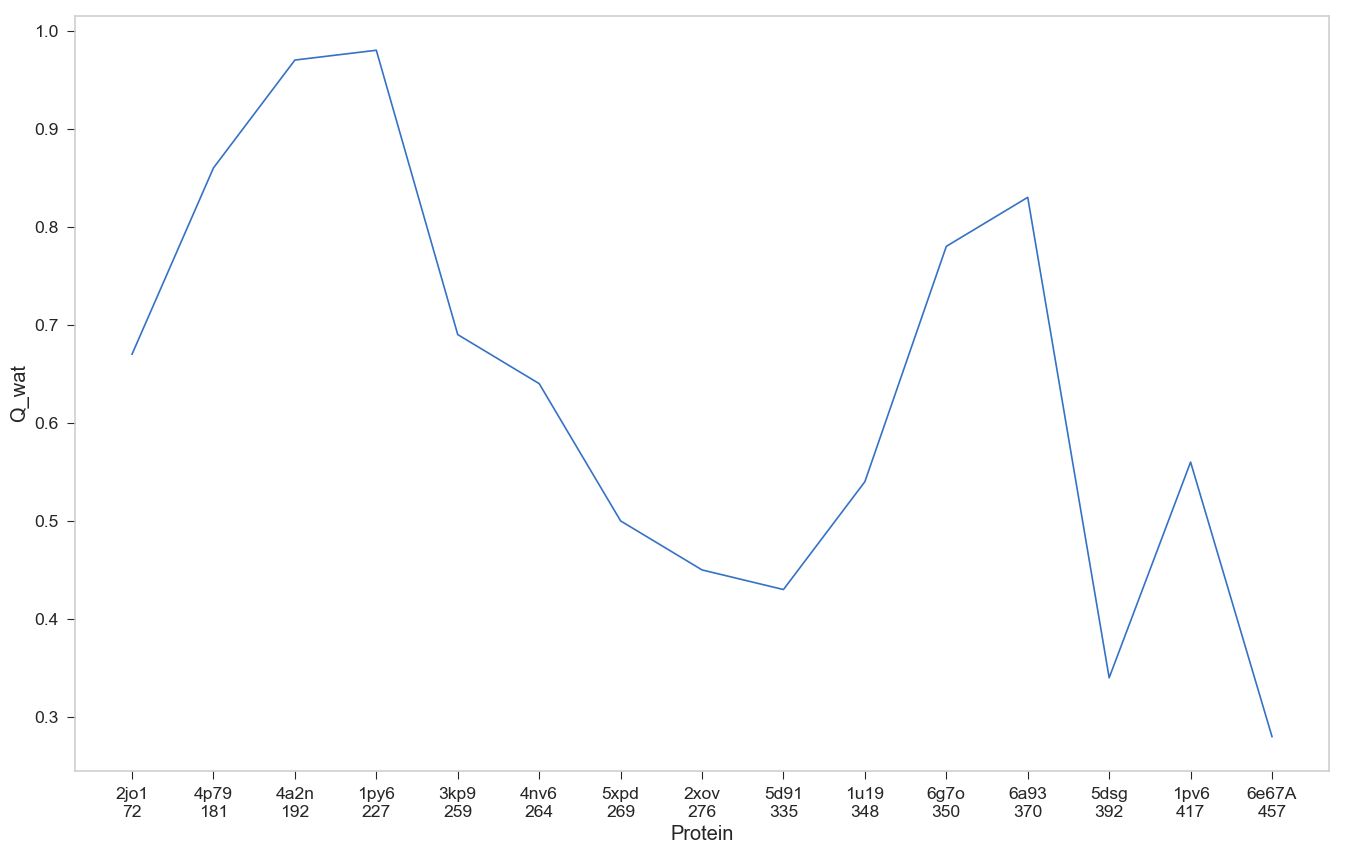

In [50]:
y = "Q_wat"
d = data.query("Steps > 200").reset_index(drop=True)

t = d.groupby(["Protein"])[y].idxmax().reset_index()
max_Q_data = d.iloc[t[y].to_list()].reset_index(drop=True)

ax = sns.lineplot(x="Protein", y=y, markers=True, ms=10, data=max_Q_data)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')


In [74]:
# check time spent
simulationType = "hybrid_protein_simulation"
# folder = "original"
# folder = "first"
# folder = "second_withoutExclusion"
# folder_list = ["first", "second_withoutExclusion"]
folder_list = ["third"]
all_data = []
for folder in folder_list:
    for pdb in pdb_list:
        for i in range(20):
            try:
                location = f"/Users/weilu/Research/server/aug_2019/{simulationType}/{folder}/{pdb}/{i}/time.dat"
                tmp = np.loadtxt(location)
            except Exception as e:
                print(e)
                tmp = -1
            all_data.append([pdb, i, float(tmp), folder])
timeData = pd.DataFrame(all_data, columns=["Protein", "i", "time", "Folder"])
timeData = timeData.merge(length_info, on="Protein")

In [75]:
timeData["Platform"] = timeData["i"].apply(lambda x: "CUDA" if x > 15 else "OpenCL")

In [76]:
plt.rcParams['figure.figsize'] = 0.5*np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

Text(0.5, 1.0, 'y = 0.34*x + 48.37')

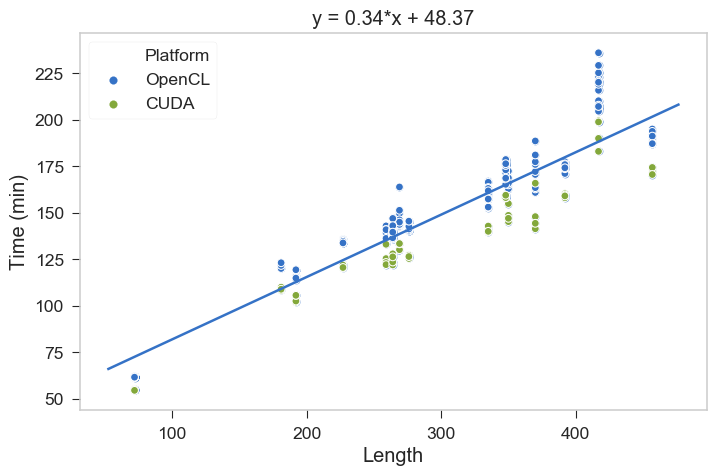

In [77]:
timeData["Time (h)"] = timeData.time / 3600
timeData = timeData.query("time != -1").reset_index(drop=True)


from sklearn.linear_model import LinearRegression
timeData["Time (min)"] = timeData.time / 60
X = timeData.Length.values.reshape(-1, 1)
y = timeData["Time (min)"].values
reg = LinearRegression().fit(X, y)

sns.regplot("Length", "Time (min)", data=timeData, ci=0)
# sns.lmplot("Length", "Time (min)", data=timeData, ci=0, hue="CUDA")
sns.scatterplot("Length", "Time (min)", data=timeData, ci=0, hue="Platform")
plt.title(f"y = {reg.coef_[0]:.2}*x + {reg.intercept_:.2f}")
# x = np.linspace(0, 500)
# plt.plot(x, x*reg.coef_[0] + reg.intercept_)

In [58]:
complete_timeData = timeData

In [61]:
# check time spent
simulationType = "cftr_frag"
# folder = "original"
# folder = "first"
# folder = "second_withoutExclusion"
# folder_list = ["first", "second_withoutExclusion"]
folder_list = ["third"]

all_data = []
for folder in folder_list:
    for pdb in ["5uak"]:
        for i in range(2):
            try:
                location = f"/Users/weilu/Research/server/aug_2019/{simulationType}/run_{i}/time.dat"
                tmp = np.loadtxt(location)
            except Exception as e:
                print(e)
                tmp = -1
            all_data.append([pdb, i, float(tmp), folder])
timeData = pd.DataFrame(all_data, columns=["Protein", "i", "time", "Folder"])
# timeData = timeData.merge(length_info, on="Protein")

In [63]:
timeData["Length"] = 1432

In [68]:
timeData["Time (min)"] = timeData["time"] / 10 * 8 / 60
timeData["Platform"] = "CUDA"

In [70]:
timeData_all = pd.concat([complete_timeData, timeData], sort=False)

Text(0.5, 1.0, 'y = 0.34*x + 48.37')

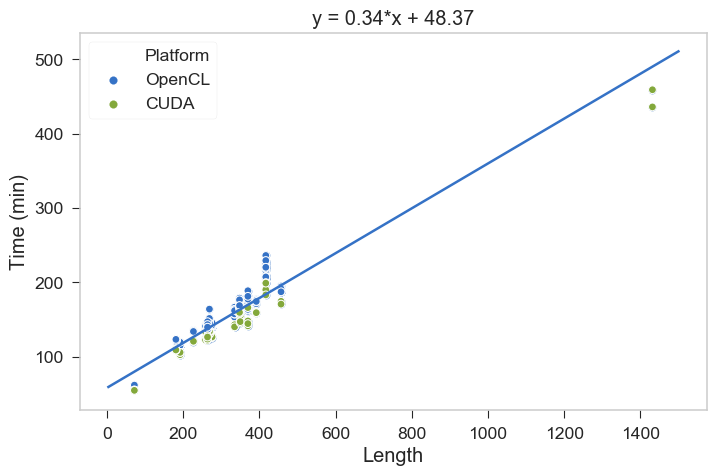

In [73]:

from sklearn.linear_model import LinearRegression
complete_timeData["Time (min)"] = complete_timeData.time / 60
X = complete_timeData.Length.values.reshape(-1, 1)
y = complete_timeData["Time (min)"].values
reg = LinearRegression().fit(X, y)

sns.regplot("Length", "Time (min)", data=timeData_all, ci=0)
# sns.lmplot("Length", "Time (min)", data=timeData, ci=0, hue="CUDA")
sns.scatterplot("Length", "Time (min)", data=timeData_all, ci=0, hue="Platform")
plt.title(f"y = {reg.coef_[0]:.2}*x + {reg.intercept_:.2f}")
# x = np.linspace(0, 500)
# plt.plot(x, x*reg.coef_[0] + reg.intercept_)

In [79]:
timeData_all.to_csv("/Users/weilu/Research/data/openMM/time_aug17.csv")

In [49]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [77]:
# 400 reisdues, 8 millions steps, 3 hours.

184.37

In [76]:
(0.34*400+48.37) / 8

23.04625

In [78]:
(1432*0.34+50)/2

268.44000000000005

In [50]:
from bokeh.palettes import Spectral5
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
import bokeh
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.iris import flowers



p = figure(title = f"y = {reg.coef_[0]:.2}*x + {reg.intercept_:.2f}", plot_height=600, plot_width=970)
p.circle(x='Length', y='Time (min)',
         source=timeData, fill_color=factor_cmap('Platform', palette=['Red', 'Blue'], factors=["OpenCL", "CUDA"]),
         size=10, legend='Platform')


# output_file("iris.html", title="iris.py example")
x = np.linspace(0, 500)
p.line(x, x*reg.coef_[0] + reg.intercept_)
show(p)

NameError: name 'reg' is not defined

In [74]:
from bokeh.palettes import Spectral5
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
import bokeh
from bokeh.plotting import figure, show, output_file
from bokeh.sampledata.iris import flowers



p = figure(title = f"y = {reg.coef_[0]:.2}*x + {reg.intercept_:.2f}", plot_height=600, plot_width=970)
p.circle(x='Length', y='Time (min)',
         source=timeData, fill_color=factor_cmap('Platform', palette=['Red', 'Blue'], factors=["OpenCL", "CUDA"]),
         size=10, legend='Platform')


# output_file("iris.html", title="iris.py example")
x = np.linspace(0, 500)
p.line(x, x*reg.coef_[0] + reg.intercept_)
show(p)

In [6]:
# time check
simulationType = "hybrid_protein_simulation"
# folder = "original"
# folder = "first"
# folder = "second_withoutExclusion"
# folder_list = ["first", "second_withoutExclusion"]
folder_list = ["third"]
all_data = []
for folder in folder_list:
    for pdb in pdb_list:
        for i in range(4):
            try:
                location = f"/Users/weilu/Research/server/aug_2019/{simulationType}/{folder}/{pdb}/{i}/time.dat"
                tmp = np.loadtxt(location)
            except Exception as e:
                print(e)
                tmp = -1
            all_data.append([pdb, i, float(tmp), folder])
timeData = pd.DataFrame(all_data, columns=["Protein", "i", "time", "Folder"])

/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/6e67A/3/time.dat not found.
/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/5d91/3/time.dat not found.
/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/5dsg/3/time.dat not found.
/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/6g7o/3/time.dat not found.
/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/6a93/3/time.dat not found.
/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/1pv6/2/time.dat not found.
/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/1pv6/3/time.dat not found.
/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/third/1u19/3/time.dat not found.


In [15]:
timeData.dtypes

Protein     object
i            int64
time       float64
Folder      object
dtype: object

In [19]:
timeData["Time (h)"] = timeData.time / 3600
timeData = timeData.query("time != -1").reset_index(drop=True)
timeData = timeData.merge(length_info, on="Protein")

from sklearn.linear_model import LinearRegression
timeData["Time (min)"] = timeData.time / 60
X = timeData.Length.values.reshape(-1, 1)
y = timeData["Time (min)"].values
reg = LinearRegression().fit(X, y)

sns.regplot("Length", "Time (min)", data=timeData, ci=0)
plt.title(f"y = {reg.coef_[0]:.1}*x + {reg.intercept_:.2f}")
# x = np.linspace(0, 500)
# plt.plot(x, x*reg.coef_[0] + reg.intercept_)

Text(0.5, 1.0, 'y = 0.3*x + 50.84')

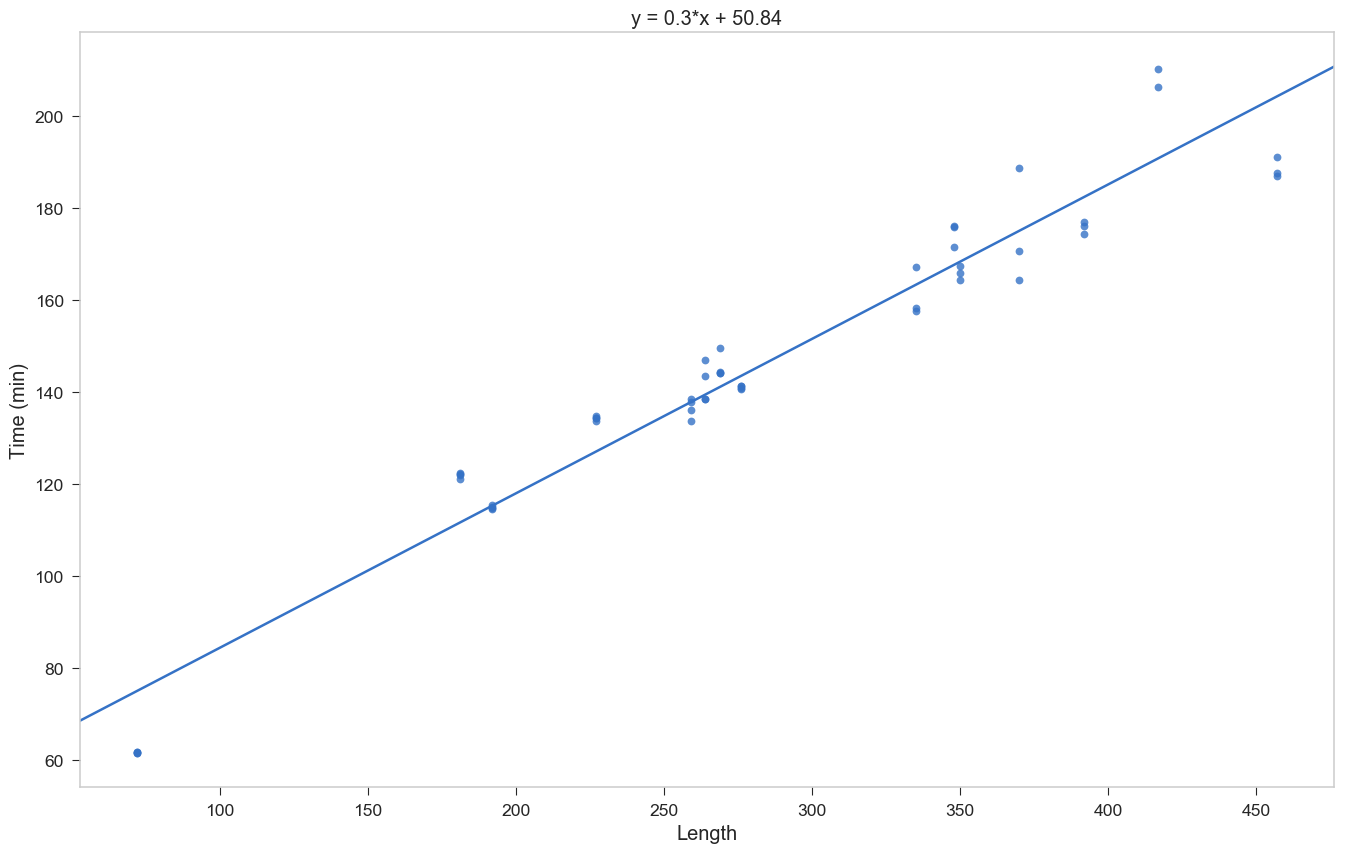

In [69]:
sns.regplot("Length", "Time (min)", data=timeData, ci=0)
plt.title(f"y = {reg.coef_[0]:.1}*x + {reg.intercept_:.2f}")
# x = np.linspace(0, 500)
# plt.plot(x, x*reg.coef_[0] + reg.intercept_)

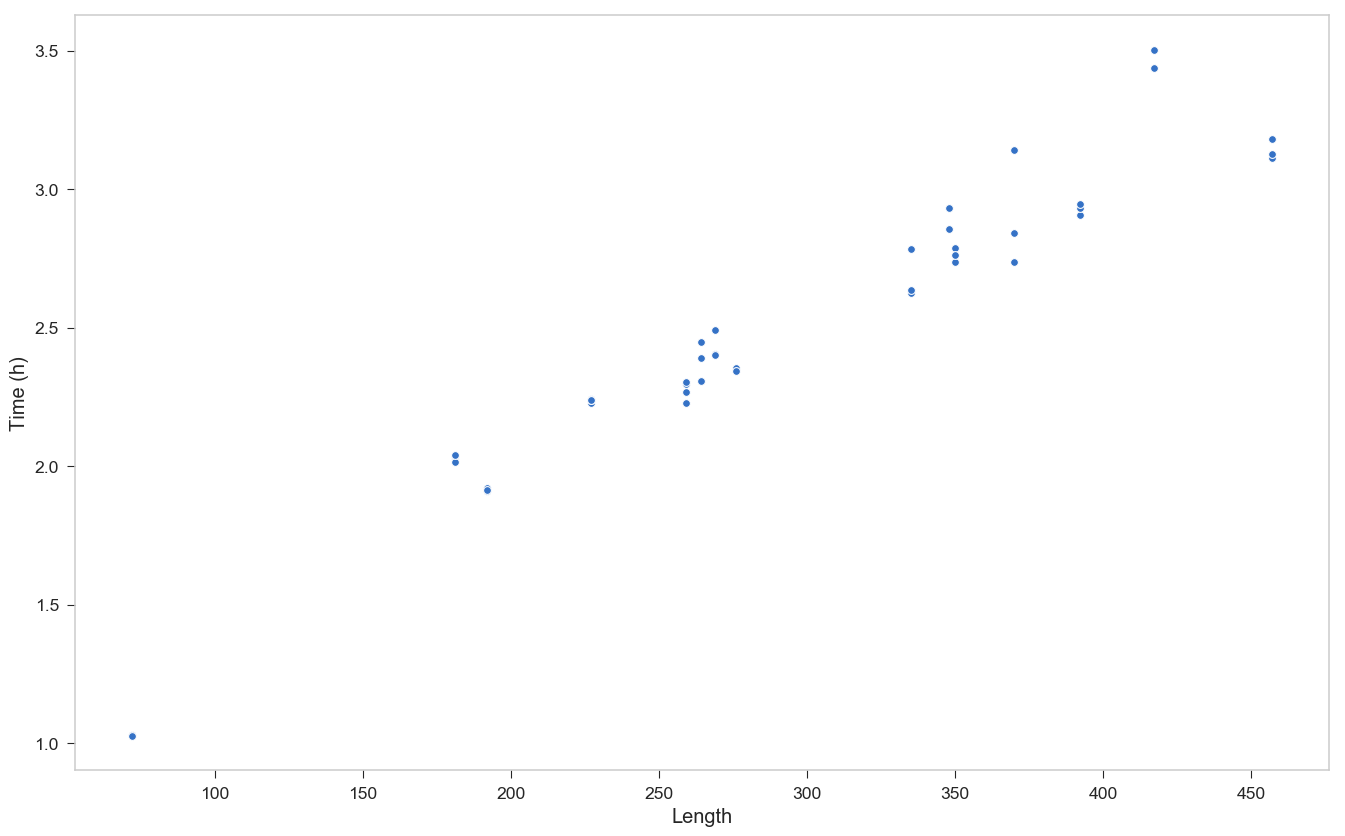

In [31]:
sns.scatterplot("Length", "Time (h)", data=timeData)

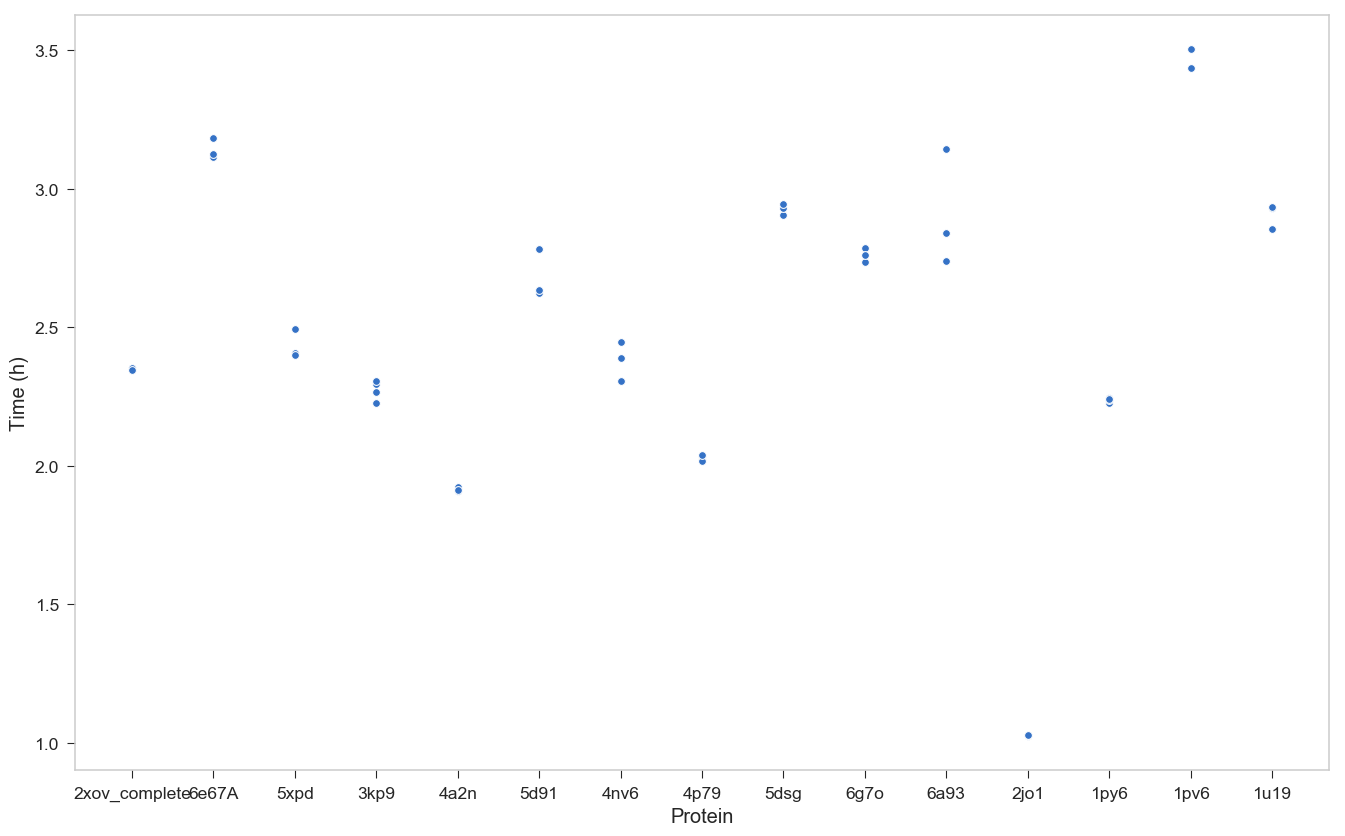

In [20]:
sns.scatterplot("Protein", "Time (h)", data=)

In [7]:
length_info = pd.read_csv("/Users/weilu/Research/server/aug_2019/hybrid_protein_simulation/length_info.csv", index_col=0)
length_info = length_info.sort_values("Length").reset_index()
pdb_list_sorted_by_length = list(length_info.Protein.unique())
length_info_sorted_by_length = list(length_info.Length.unique())
label_list = []
for p, n in zip(pdb_list_sorted_by_length, length_info_sorted_by_length):
    label_list.append(p+f"\n{n}")

In [22]:
length_info

index        Protein  Length  \
0      11           2jo1      72   
1       7           4p79     181   
2       4           4a2n     192   
3      12           1py6     227   
4       3           3kp9     259   
5       6           4nv6     264   
6       2           5xpd     269   
7       0  2xov_complete     276   
8       5           5d91     335   
9      14           1u19     348   
10      9           6g7o     350   
11     10           6a93     370   
12      8           5dsg     392   
13     13           1pv6     417   
14      1          6e67A     457   

                                                 Name  \
0   Structure of the Na K-ATPase regulatory protei...   
1                                    mouse claudin-15   
2                                             Ma-ICMT   
3         Bacteriorhodopsin crystallized from bicells   
4    bacterial homolog of vitamin K epoxide reductase   
5           intramembrane vitamin K epoxide reductase   
6                      Sugar transporter of AtSWEET13   
7                                                 NaN   
8   phosphatidylinositolphosphate (PIP) synthase f...   
9                                    Bovine Rhodopsin   
10                human alkaline ceramidase 3 (ACER3)   
11                5-HT2AR in complex with risperidone   
12     M4 muscarinic acetylcholine receptor (M4-mT4L)   
13                                   lactose permease   
14    beta2 adrenergic receptor fused to a Gs peptide   

                                                Paper  
0                                                 NaN  
1   Crystal Structure of a Claudin Provides Insigh...  
2   Mechanism of Isoprenylcysteine Carboxyl Methyl...  
3   Side-chain Contributions to Membrane Protein S...  
4   Structure of a bacterial homologue of vitamin ...  
5   Structures of an intramembrane vitamin K epoxi...  
6   Molecular mechanism of substrate recognition a...  
7                                                 NaN  
8                                                 NaN  
9   The Retinal Conformation and its Environment i...  
10  Structure of a human intramembrane ceramidase ...  
11  Structures of the 5-HT2A receptor in complex w...  
12  Crystal structures of the M1 and M4 muscarinic...  
13  Structure and Mechanism of the Lactose Permeas...  
14  Structural Insights into the Process of GPCR-G...

In [19]:
# time check
simulationType = "group1_hybrid_simulation"
# folder = "original"
# folder = "first"
# folder = "second_withoutExclusion"
folder_list = ["first", "second_withoutExclusion"]
all_data = []
for folder in folder_list:
    for pdb in pdb_list:
        for i in range(2):
            location = f"/Users/weilu/Research/server/jul_2019/{simulationType}/{folder}/{pdb}/{i}/time.dat"
            tmp = np.loadtxt(location)
            all_data.append([pdb, i, float(tmp), folder])


In [25]:
timeData

Protein  i          time                   Folder
0            4a2n  0   9577.809066                    first
1            4a2n  1   9337.112881                    first
2            3kp9  0  10604.559031                    first
3            3kp9  1  10735.342127                    first
4            5xpd  0  11127.230986                    first
5            5xpd  1  11055.921038                    first
6   2xov_complete  0  10939.072847                    first
7   2xov_complete  1  11012.186129                    first
8            5d91  0  12170.476401                    first
9            5d91  1  11664.293869                    first
10          6e67A  0  13360.377946                    first
11          6e67A  1  14039.109251                    first
12           4a2n  0   9828.883013  second_withoutExclusion
13           4a2n  1  10154.168683  second_withoutExclusion
14           3kp9  0  11071.361127  second_withoutExclusion
15           3kp9  1  11583.144578  second_withoutExclusion
16           5xpd  0  11512.174286  second_withoutExclusion
17           5xpd  1  11202.616220  second_withoutExclusion
18  2xov_complete  0  11218.423627  second_withoutExclusion
19  2xov_complete  1  11492.046522  second_withoutExclusion
20           5d91  0  12750.053688  second_withoutExclusion
21           5d91  1  12421.726150  second_withoutExclusion
22          6e67A  0  13949.016609  second_withoutExclusion
23          6e67A  1  13823.596369  second_withoutExclusion

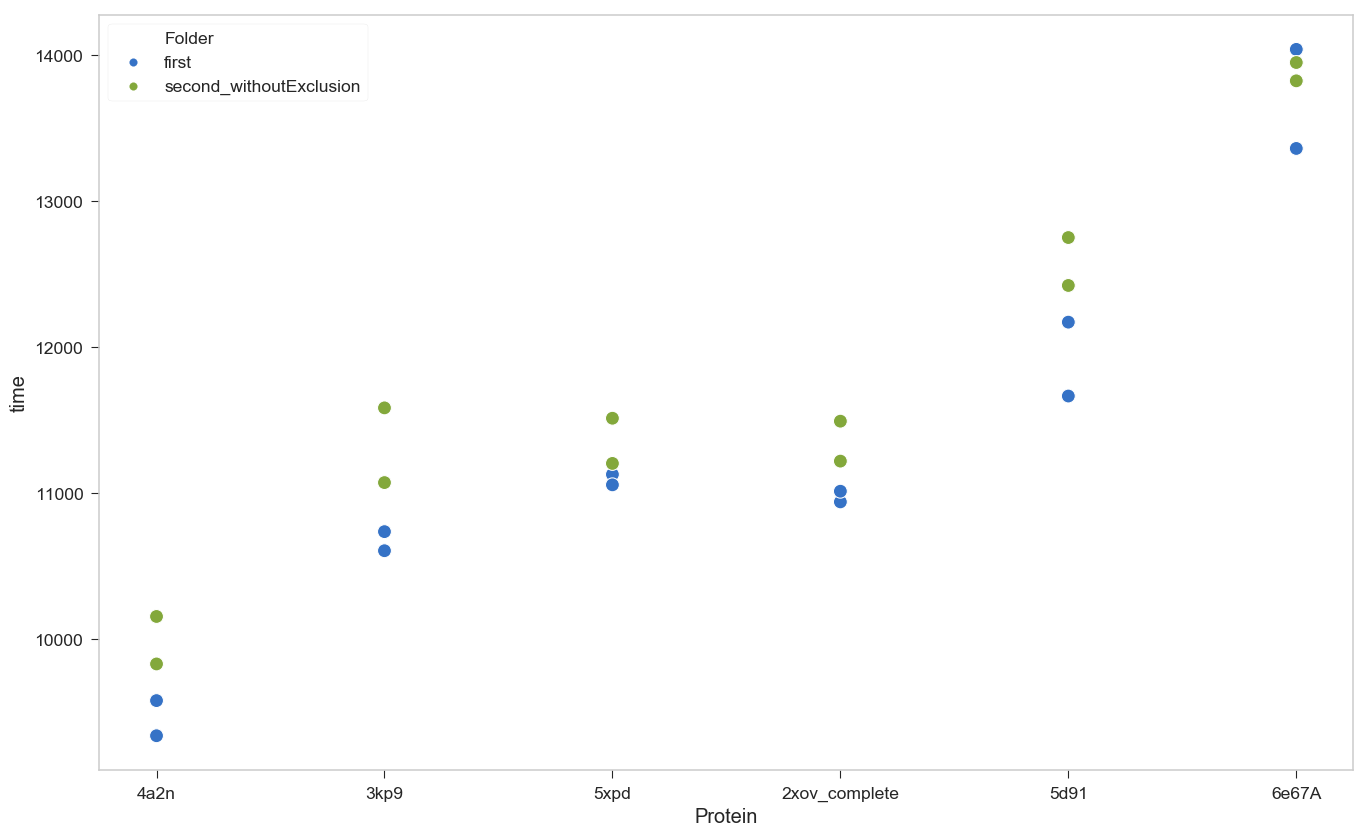

In [33]:
ax = sns.scatterplot("Protein", "time", hue="Folder", s=100, data=timeData)

In [68]:
simulationType = "group1_hybrid_simulation"
# folder = "original"
# folder = "first"
folder = "third_without_contact"
all_data = []
for pdb in pdb_list:
    for i in range(3):
        for restart in range(1):
            pre = f"/Users/weilu/Research/server/jul_2019/{simulationType}/{folder}/{pdb}/{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
                all_data.append(tmp)
            except:
                print(pdb, i, restart)
                pass
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
data.reset_index(drop=True).to_csv(f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}_no_contact.csv")


In [13]:
simulationType = "group1_hybrid_simulation"
# folder = "original"
# folder = "first"
folder = "second_withoutExclusion"
all_data = []
for pdb in pdb_list:
    for i in range(2):
        for restart in range(1):
            pre = f"/Users/weilu/Research/server/jul_2019/{simulationType}/{folder}/{pdb}/{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
                all_data.append(tmp)
            except:
                print(pdb, i, restart)
                pass
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
data.reset_index(drop=True).to_csv(f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}_er.csv")


In [67]:
datetime.today().strftime('%m-%d_%H_%M_%S')

'07-12_21_50_42'

In [50]:
from simtk.unit import angstrom
from simtk.unit import kilocalorie_per_mole

In [51]:
type(angstrom)

simtk.unit.unit.Unit

In [65]:
isinstance(1*angstrom, Quantity)

True

In [61]:
from simtk.unit.quantity import Quantity

In [64]:
Quantity()

Quantity(value=[], unit=dimensionless)

In [62]:
type(10*kilocalorie_per_mole) == Quantity

True

In [69]:
fileLocation = "/Users/weilu/Research/data/openMM/group1_hybrid_simulation_third_without_contact_07-15_no_contact.csv"
third = pd.read_csv(fileLocation, index_col=0).reset_index(drop=True)


In [70]:
fileLocation = "/Users/weilu/Research/data/openMM/group1_hybrid_simulation_first_07-12_er.csv"
first = pd.read_csv(fileLocation, index_col=0).reset_index(drop=True)


In [71]:
fileLocation = "/Users/weilu/Research/data/openMM/group1_hybrid_simulation_second_withoutExclusion_07-12_er.csv"
second = pd.read_csv(fileLocation, index_col=0).reset_index(drop=True)


In [72]:
combined = pd.concat([first.assign(Folder="first"), second.assign(Folder="second"),
                     third.assign(Folder="third")], sort=False).reset_index(drop=True)

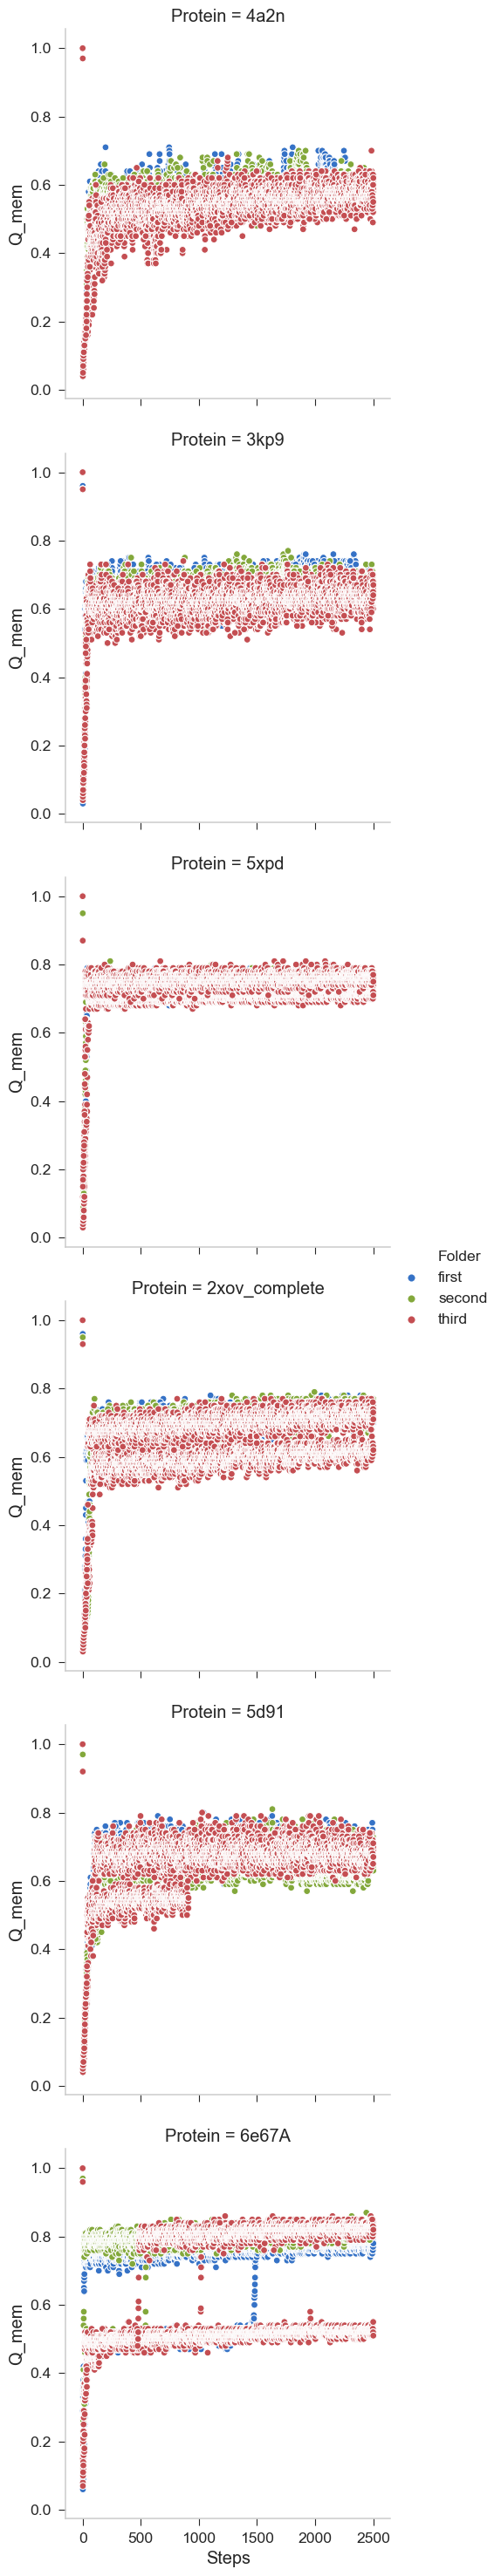

In [74]:
sns.relplot("Steps", "Q_mem", hue="Folder", col="Protein", data=combined, col_wrap=1)

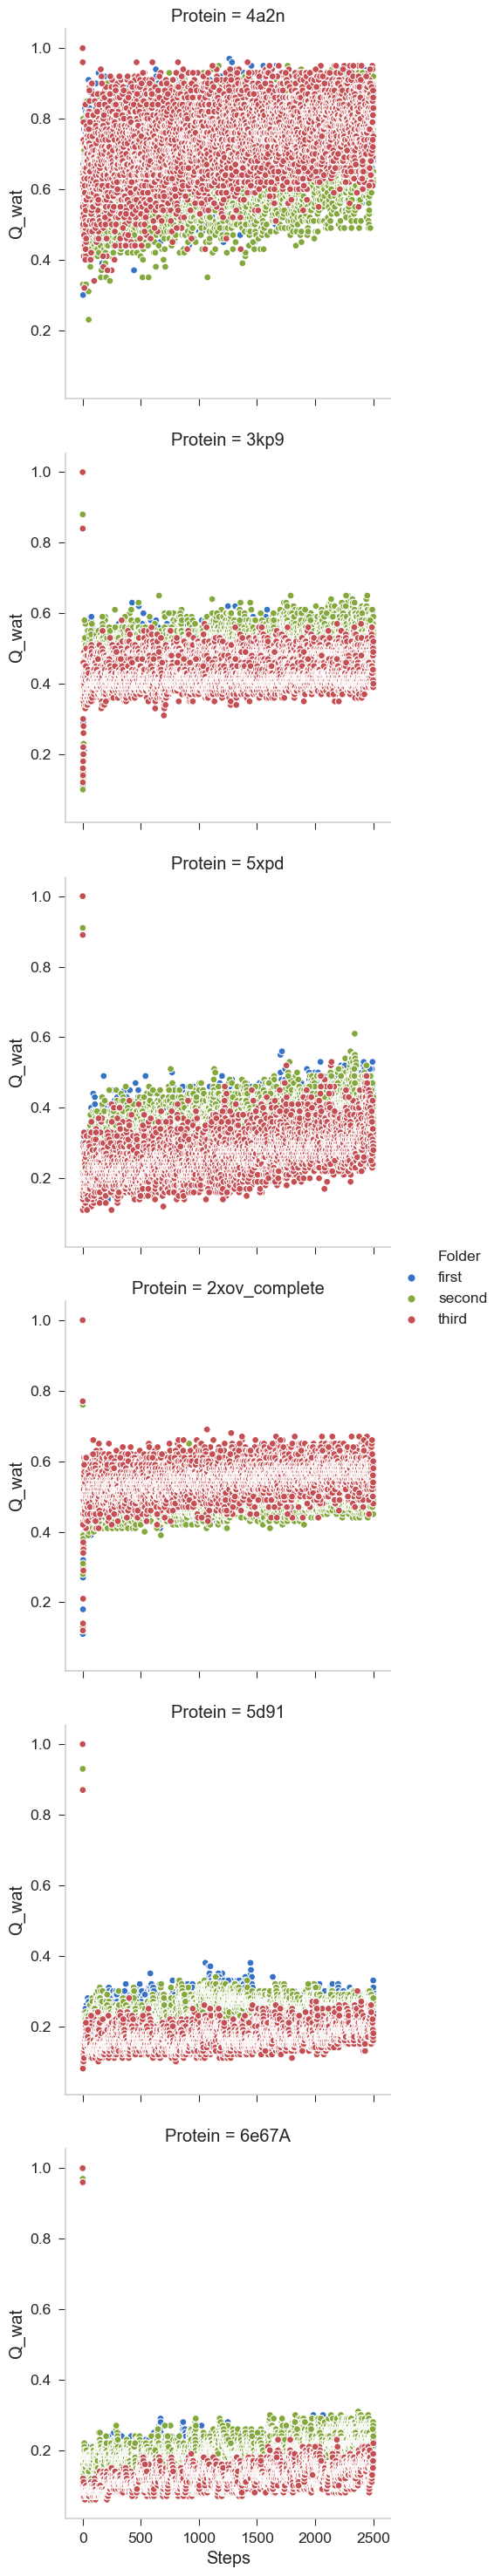

In [73]:
sns.relplot("Steps", "Q_wat", hue="Folder", col="Protein", data=combined, col_wrap=1)

In [40]:
combined = pd.concat([first.assign(Folder="first"), second.assign(Folder="second")], sort=False).reset_index(drop=True)

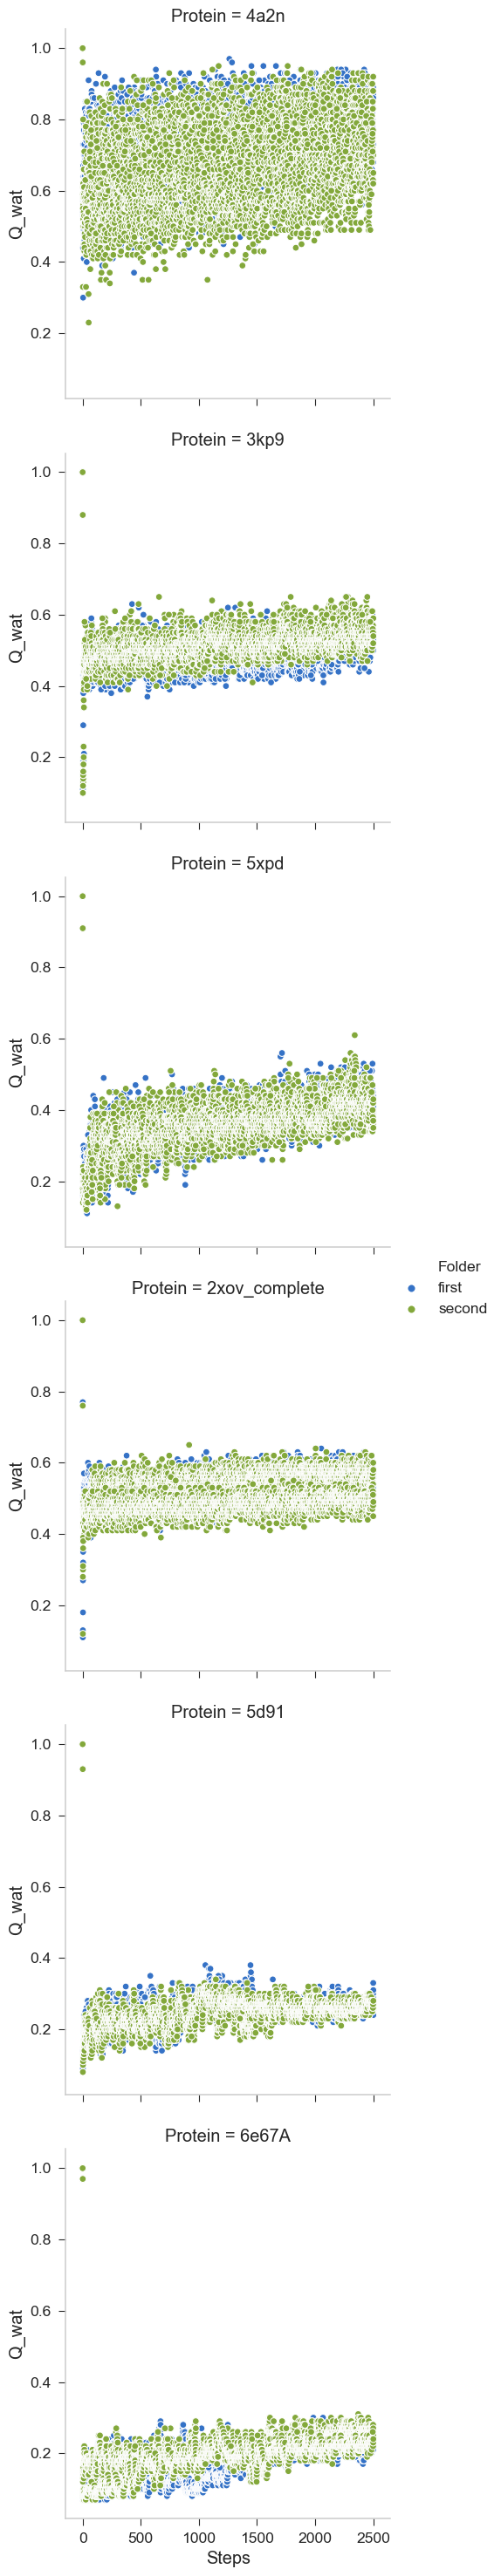

In [48]:
sns.relplot("Steps", "Q_wat", hue="Folder", col="Protein", data=combined, col_wrap=1)

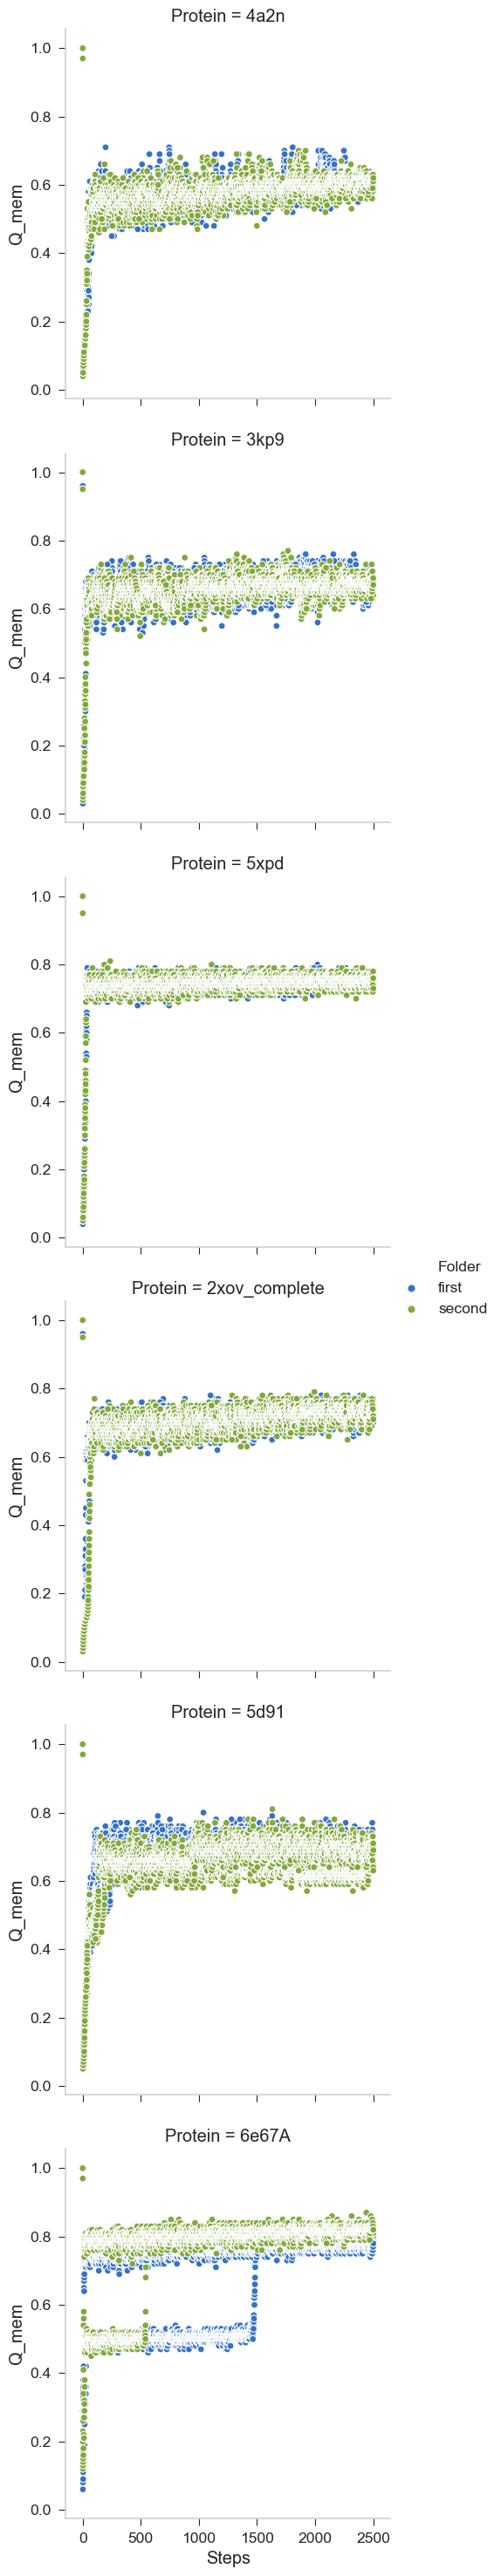

In [49]:
sns.relplot("Steps", "Q_mem", hue="Folder", col="Protein", data=combined, col_wrap=1)

In [43]:
combined.columns

Index(['Steps', 'Q', 'Qc', 'Q_wat', 'Q_mem', 'Rg', 'Pulling', 'Con', 'Chain',
       'Chi', 'Excluded', 'Rama', 'Contact', 'Helical', 'Fragment', 'Membrane',
       'ER', 'Beta', 'Pap', 'Rg_Bias', 'Total', 'Run', 'Protein', 'Restart',
       'Folder'],
      dtype='object')

In [42]:
combined.shape

(60048, 25)

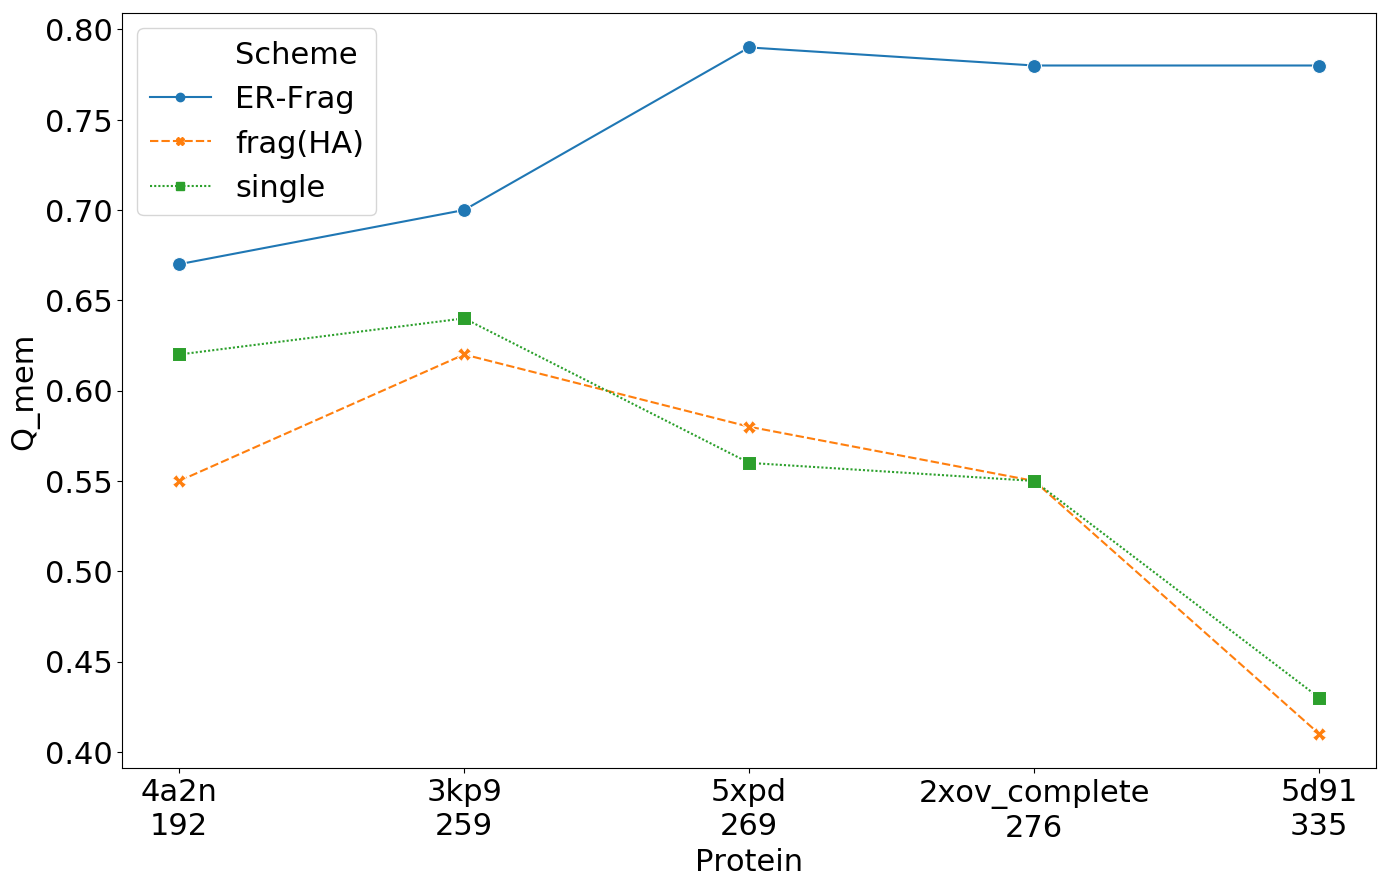

In [311]:
y = "Q_mem"
d = combined.query("Steps > 200").reset_index(drop=True)

# max_Q_data = d.groupby(["Protein", "Frag"])["Q_wat"].max().reset_index()
d = d.query("Protein != '2jo1'").reset_index(drop=True)
sub_pdb_list =['4a2n', '3kp9', '5xpd', '2xov_complete', '5d91']
# pdb_list =
sub_label_list = []
for p, n in zip(pdb_list_sorted_by_length, length_info_sorted_by_length):
    if p in sub_pdb_list:
        sub_label_list.append(p+f"\n{n}")
        
d.Protein = pd.Categorical(d.Protein, 
                      categories=sub_pdb_list)
t = d.groupby(["Protein", "Scheme"])[y].idxmax().reset_index()
max_Q_data = d.iloc[t[y].to_list()].reset_index(drop=True)

ax = sns.lineplot(x="Protein", y=y, hue="Scheme", style="Scheme", markers=True, ms=10, data=max_Q_data)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')



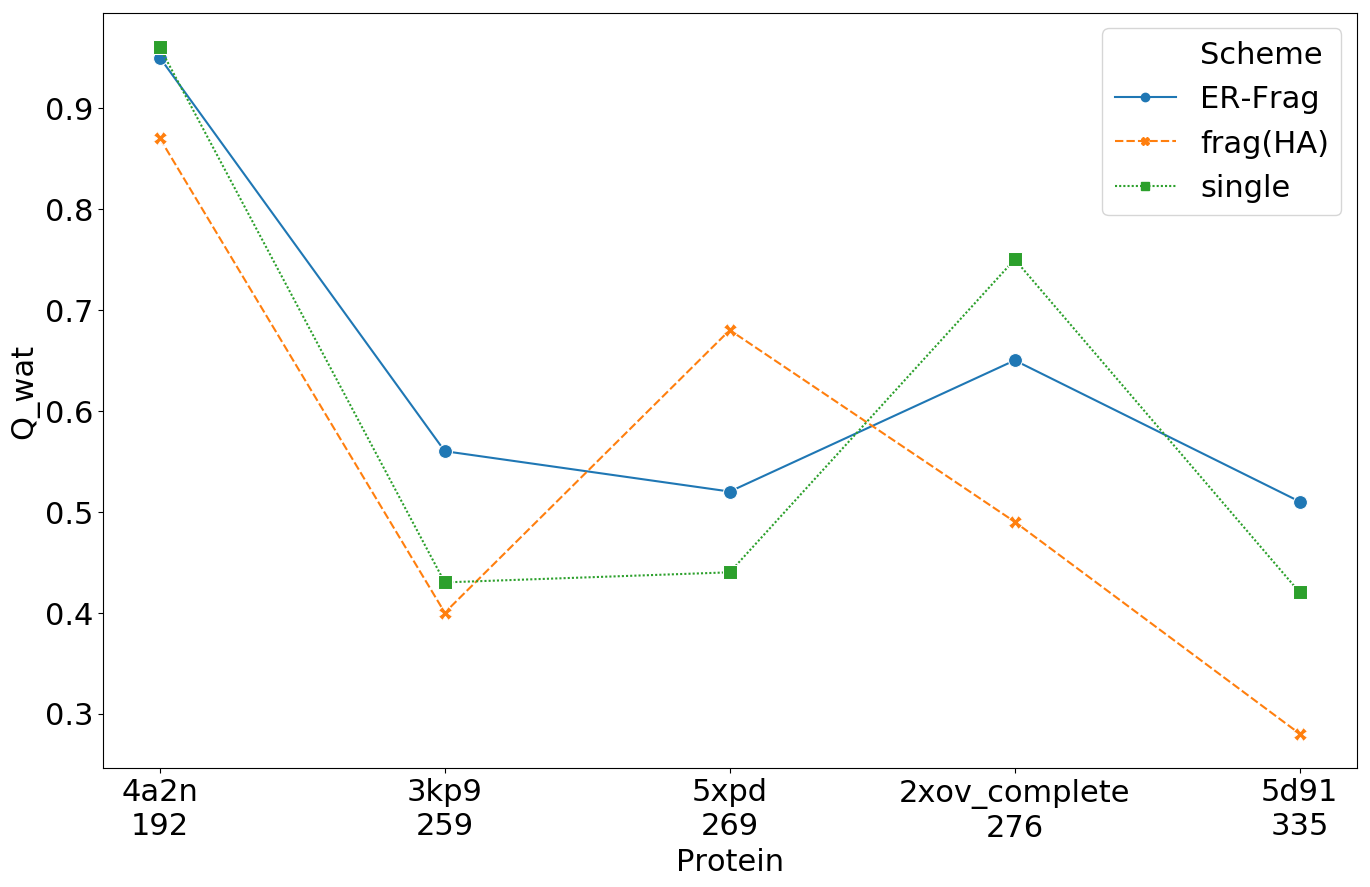

In [284]:
y = "Q_wat"
d = combined.query("Steps > 200").reset_index(drop=True)

# max_Q_data = d.groupby(["Protein", "Frag"])["Q_wat"].max().reset_index()
d = d.query("Protein != '2jo1'").reset_index(drop=True)
sub_pdb_list =['4a2n', '3kp9', '5xpd', '2xov_complete', '5d91']
# pdb_list =
sub_label_list = []
for p, n in zip(pdb_list_sorted_by_length, length_info_sorted_by_length):
    if p in sub_pdb_list:
        sub_label_list.append(p+f"\n{n}")
        
d.Protein = pd.Categorical(d.Protein, 
                      categories=sub_pdb_list)
t = d.groupby(["Protein", "Scheme"])[y].idxmax().reset_index()
max_Q_data = d.iloc[t[y].to_list()].reset_index(drop=True)

ax = sns.lineplot(x="Protein", y=y, hue="Scheme", style="Scheme", markers=True, ms=10, data=max_Q_data)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')



In [286]:
max_Q_data.query("Scheme == 'ER-Frag'")

Steps     Q    Qc  Q_wat  Q_mem     Rg  Pulling     Con   Chain     Chi  \
0   204    0.38  0.56  0.95   0.54   19.02  0.0      601.00  357.10  109.27   
3   245    0.31  0.45  0.56   0.68   28.90  0.0      752.16  504.92  139.16   
6   486    0.40  0.59  0.52   0.76   23.11  0.0      553.16  409.70  120.86   
9   232    0.32  0.49  0.65   0.71   32.84  0.0      791.39  563.45  145.64   
12  444    0.35  0.55  0.51   0.68   26.42  0.0      756.83  525.84  130.64   

    Excluded     Rama  Contact  Helical  Fragment  Membrane   Beta    Pap  \
0   45.39    -906.29  -236.07  -80.16   -693.52   -434.05   -0.10  -0.00    
3   55.12    -1186.30 -341.01  -103.20  -1113.93  -469.42   -25.00 -14.69   
6   59.78    -1606.65 -359.40  -157.95  -1173.91  -633.37   -22.88 -7.38    
9   62.34    -1109.21 -339.87  -104.98  -1169.36  -509.69   -21.66 -12.98   
12  69.06    -1937.75 -484.32  -154.77  -1577.79  -488.36   -51.15 -20.91   

    Rg_Bias    Total  Run        Protein  Restart   Scheme       ER  
0   13.59   -1766.71  0    4a2n           0        ER-Frag -542.87   
3   11.01   -2639.87  0    3kp9           0        ER-Frag -848.70   
6   16.21   -3987.03  0    5xpd           0        ER-Frag -1185.21  
9   16.31   -2934.56  1    2xov_complete  0        ER-Frag -1245.95  
12  20.63   -4426.46  0    5d91           0        ER-Frag -1214.39

In [302]:
d = max_Q_data.query("Scheme == 'ER-Frag'")
for i, line in d.iterrows():
    run = line["Run"]
    pdb = line["Protein"]
    step = line["Steps"]
    print(pdb, run, step)
    get_best_frame_and_extract(pdb, run, step)

In [316]:
d = max_Q_data.query("Scheme == 'ER-Frag'")
for i, line in d.iterrows():
    run = line["Run"]
    pdb = line["Protein"]
    step = line["Steps"]
    print(pdb, run, step)
    get_best_frame_and_extract(pdb, run, step, Q="Q_mem")

4a2n 0 231
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] , 
[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64] , 
[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92] , 
[130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159] , 
Globular 92 130
size 192
 Globular 159 192
3kp9 0 462
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] , 
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69] , 
[83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102] , 
[109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129] , 
[138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155] , 
size 259
 Globular 155 259
5xpd 0 285
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2

In [314]:
max_Q_data.query("Scheme == 'ER-Frag'")

Steps     Q    Qc  Q_wat  Q_mem     Rg  Pulling     Con   Chain     Chi  \
0   231    0.48  0.69  0.79   0.67   18.48  0.0      628.78  387.50  118.15   
3   462    0.33  0.49  0.46   0.70   26.07  0.0      571.73  391.87  97.26    
6   285    0.43  0.59  0.40   0.79   22.31  0.0      748.41  540.84  122.86   
9   407    0.39  0.58  0.49   0.78   30.29  0.0      684.69  480.58  124.82   
12  231    0.29  0.45  0.21   0.78   26.11  0.0      982.15  622.24  185.93   

    Excluded     Rama  Contact  Helical  Fragment  Membrane   Beta    Pap  \
0   44.93    -928.62  -242.70  -79.33   -688.87   -435.01   -1.14  -0.00    
3   62.37    -1305.72 -367.74  -110.62  -1159.41  -475.96   -46.59 -12.58   
6   63.62    -1591.76 -349.13  -156.64  -1168.47  -642.02   -24.47 -4.76    
9   61.74    -1261.85 -374.84  -123.66  -1185.01  -497.02   -13.26 -16.61   
12  103.13   -1802.82 -448.55  -144.58  -1522.05  -500.53   -11.37 -4.52    

    Rg_Bias    Total  Run        Protein  Restart   Scheme       ER  
0   16.80   -1758.72  0    4a2n           0        ER-Frag -579.21   
3   12.29   -3208.14  0    3kp9           0        ER-Frag -865.04   
6   14.15   -3636.28  0    5xpd           0        ER-Frag -1188.91  
9   17.71   -3364.84  0    2xov_complete  0        ER-Frag -1262.12  
12  27.04   -3662.01  0    5d91           0        ER-Frag -1148.08

In [265]:
max_Q_data

Steps     Q    Qc  Q_wat  Q_mem     Rg  Pulling     Con   Chain     Chi  \
0   214    0.44  0.62  0.92   0.59   18.96  0.0      306.95  237.63  73.21    
1   227    0.29  0.48  0.87   0.52   19.42  0.0      320.84  196.01  60.42    
2   206    0.34  0.52  0.96   0.55   18.27  0.0      337.19  229.50  77.95    
3   234    0.34  0.53  0.54   0.63   24.13  0.0      424.38  251.36  76.94    
4   205    0.25  0.40  0.40   0.58   24.64  0.0      436.53  294.70  85.08    
5   236    0.32  0.49  0.43   0.60   23.56  0.0      411.36  296.72  77.98    
6   203    0.30  0.48  0.66   0.65   31.29  0.0      470.85  313.90  91.88    
7   216    0.22  0.37  0.49   0.46   33.76  0.0      455.54  275.36  83.83    
8   217    0.27  0.45  0.75   0.50   31.80  0.0      489.19  313.38  94.38    
9   212    0.29  0.45  0.29   0.68   24.17  0.0      584.25  385.11  111.29   
10  214    0.19  0.33  0.28   0.37   24.53  0.0      582.21  371.82  110.08   
11  225    0.20  0.31  0.42   0.40   21.16  0.0      534.99  362.69  113.57   

    Excluded     Rama  Contact  Helical  Fragment  Membrane    Beta     Pap  \
0   29.24    -1110.31 -260.55  -108.38  -746.00   -439.55   -17.44  -0.00     
1   24.11    -1112.79 -286.75  -98.70   -754.15   -451.17   -48.44  -8.26     
2   37.66    -1112.50 -311.21  -106.30  -664.35   -437.16   -0.91   -130.87   
3   40.30    -1327.19 -411.79  -121.50  -1200.14  -470.27   -46.74  -13.04    
4   39.15    -1366.51 -414.36  -133.78  -1212.52  -482.62   -67.88  -30.64    
5   49.56    -1380.56 -476.89  -115.48  -833.57   -483.09   -73.64  -201.86   
6   41.02    -1301.91 -401.11  -124.78  -1225.22  -521.60   -49.92  -12.88    
7   41.99    -1382.89 -420.30  -136.40  -1258.28  -537.27   -29.90  -10.34    
8   55.71    -1342.67 -497.95  -126.99  -882.63   -532.75   -65.12  -207.10   
9   66.71    -2075.43 -524.57  -178.50  -1606.17  -482.09   -86.76  -28.25    
10  56.68    -2038.92 -600.69  -161.28  -1597.45  -598.99   -102.83 -40.32    
11  73.90    -2071.98 -664.84  -147.34  -1109.80  -600.86   -124.66 -290.00   

    Rg_Bias    Total  Run        Protein  Restart    Scheme       ER  
0   13.28   -2612.78  0    4a2n           0        ER-frag  -590.86   
1   8.82    -2150.08  4    4a2n           0        frag(HA) NaN       
2   10.65   -2070.35  2    4a2n           0        single   NaN       
3   10.15   -3679.63  0    3kp9           0        ER-frag  -892.10   
4   5.98    -2846.88  4    3kp9           0        frag(HA) NaN       
5   6.67    -2722.80  0    3kp9           0        single   NaN       
6   13.37   -3818.78  1    2xov_complete  0        ER-frag  -1112.39  
7   9.53    -2909.14  0    2xov_complete  0        frag(HA) NaN       
8   11.24   -2691.31  2    2xov_complete  0        single   NaN       
9   21.94   -5033.92  0    5d91           0        ER-frag  -1221.46  
10  21.59   -3998.09  0    5d91           0        frag(HA) NaN       
11  20.33   -3904.00  2    5d91           0        single   NaN

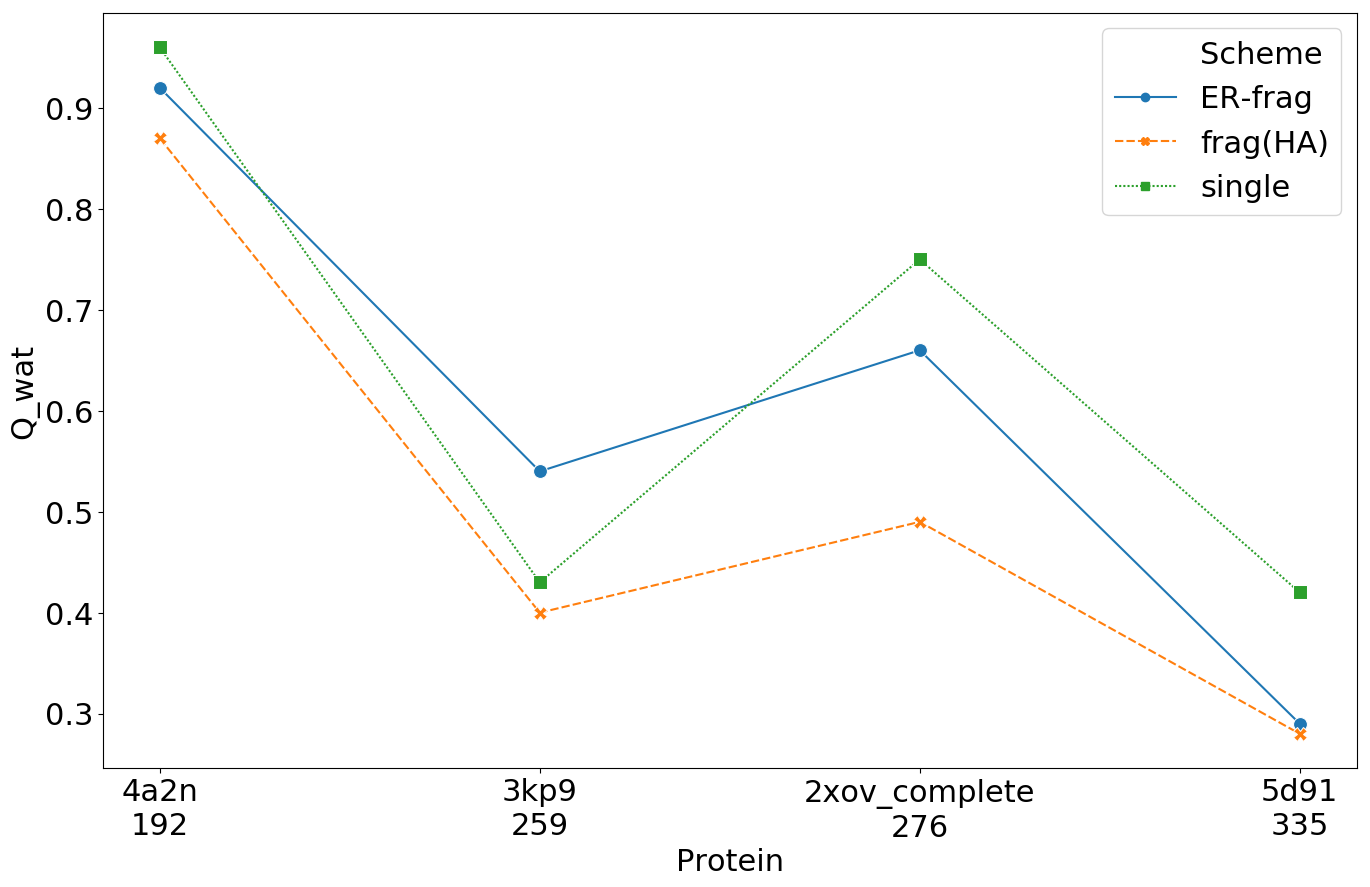

In [264]:
y = "Q_wat"
d = combined.query("Steps > 200").reset_index(drop=True)

# max_Q_data = d.groupby(["Protein", "Frag"])["Q_wat"].max().reset_index()
d = d.query("Protein != '2jo1'").query("Protein != '5xpd'").query("Protein != '6e67A'").reset_index(drop=True)
sub_pdb_list =['4a2n', '3kp9', '2xov_complete', '5d91']
d.Protein = pd.Categorical(d.Protein, 
                      categories=sub_pdb_list)
t = d.groupby(["Protein", "Scheme"])[y].idxmax().reset_index()
max_Q_data = d.iloc[t[y].to_list()].reset_index(drop=True)

ax = sns.lineplot(x="Protein", y=y, hue="Scheme", style="Scheme", markers=True, ms=10, data=max_Q_data)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')



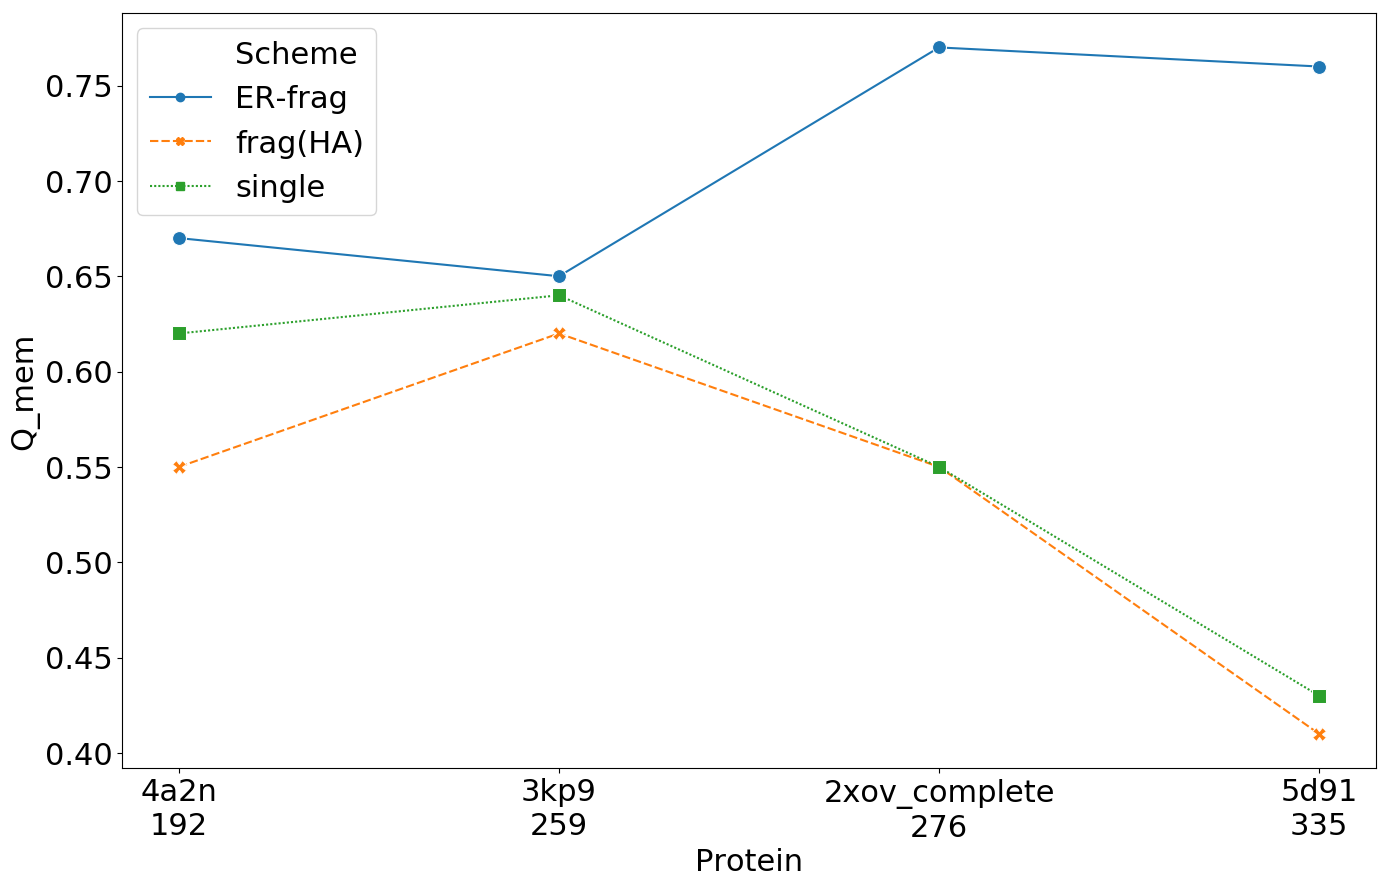

In [262]:
y = "Q_mem"
d = combined.query("Steps > 200").reset_index(drop=True)

# max_Q_data = d.groupby(["Protein", "Frag"])["Q_wat"].max().reset_index()
d = d.query("Protein != '2jo1'").query("Protein != '5xpd'").query("Protein != '6e67A'").reset_index(drop=True)
sub_pdb_list =['4a2n', '3kp9', '2xov_complete', '5d91']
d.Protein = pd.Categorical(d.Protein, 
                      categories=sub_pdb_list)
t = d.groupby(["Protein", "Scheme"])[y].idxmax().reset_index()
max_Q_data = d.iloc[t[y].to_list()].reset_index(drop=True)

ax = sns.lineplot(x="Protein", y=y, hue="Scheme", style="Scheme", markers=True, ms=10, data=max_Q_data)
_ = ax.set_xticklabels(labels=sub_label_list, rotation=0, ha='center')



In [7]:
simulationType = "simluation_hybrid"
# folder = "original"
folder = "fourth"
all_data = []
for pdb in pdb_list:
    for i in range(5):
        for restart in range(1):
            location = f"/Users/weilu/Research/server/jun_2019/{simulationType}/{folder}/{pdb}/{i}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
                all_data.append(tmp)
            except:
                print(pdb, i, restart)
                pass
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
data.reset_index(drop=True).to_csv(f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}_ha.csv")


In [8]:
fileLocation = "/Users/weilu/Research/data/openMM/simluation_hybrid_fourth_07-01_ha.csv"
ha = pd.read_csv(fileLocation, index_col=0)


In [9]:
fileLocation = "/Users/weilu/Research/data/openMM/simluation_hybrid_second_small_batch_06-29.csv"
single = pd.read_csv(fileLocation, index_col=0)



In [17]:
combined = pd.concat([single.assign(Frag="single"), ha.assign(Frag="frag(HA)")])

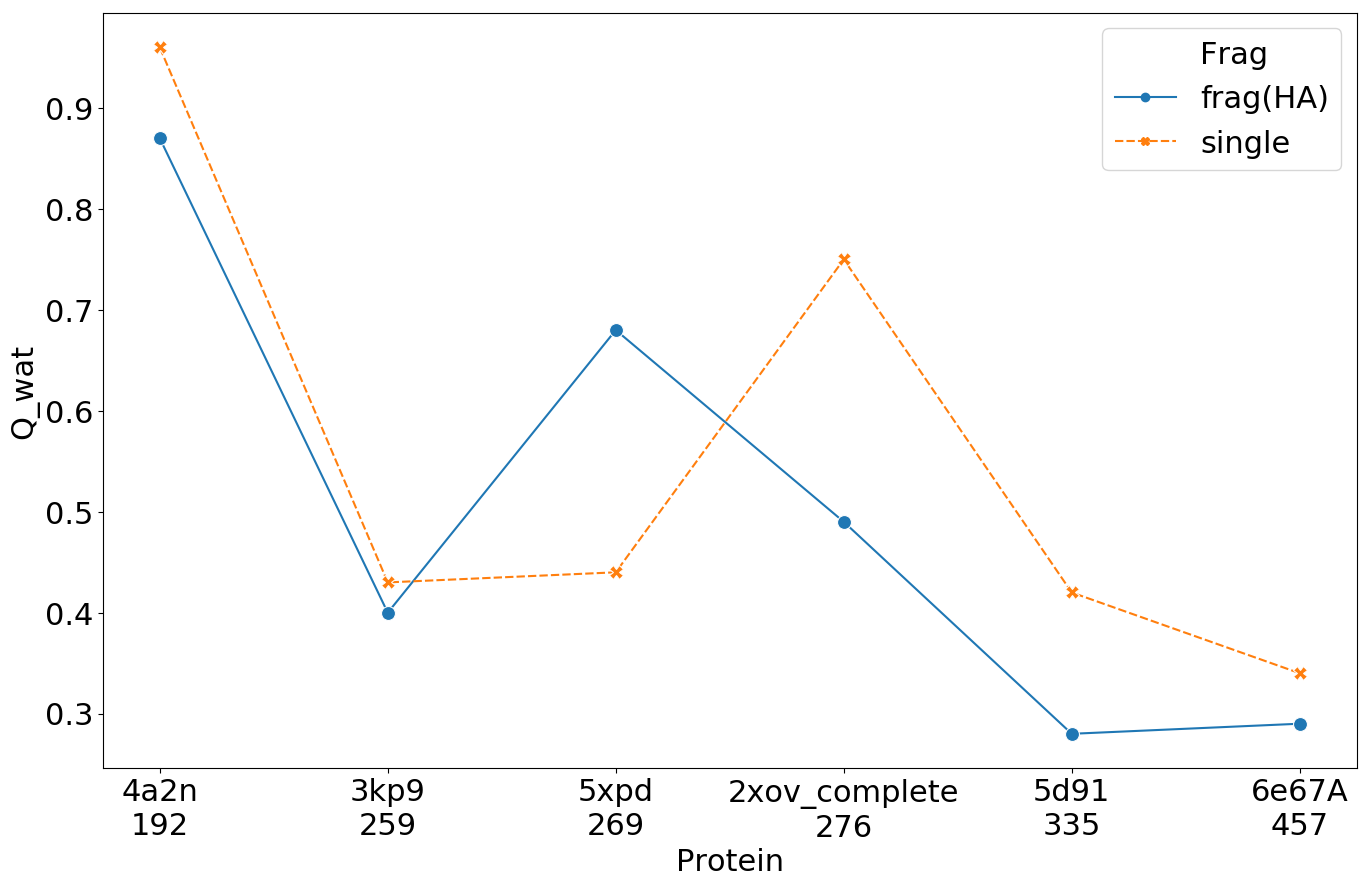

In [23]:
d = combined.query("Steps > 200").reset_index(drop=True)
d.Protein = pd.Categorical(d.Protein, 
                      categories=pdb_list)
# max_Q_data = d.groupby(["Protein", "Frag"])["Q_wat"].max().reset_index()

t = d.groupby(["Protein", "Frag"])["Q_wat"].idxmax().reset_index()
max_Q_data = d.iloc[t["Q_wat"].to_list()].reset_index(drop=True)

ax = sns.lineplot(x="Protein", y="Q_wat", hue="Frag", style="Frag", markers=True, ms=10, data=max_Q_data)
_ = ax.set_xticklabels(labels=label_list[1:], rotation=0, ha='center')



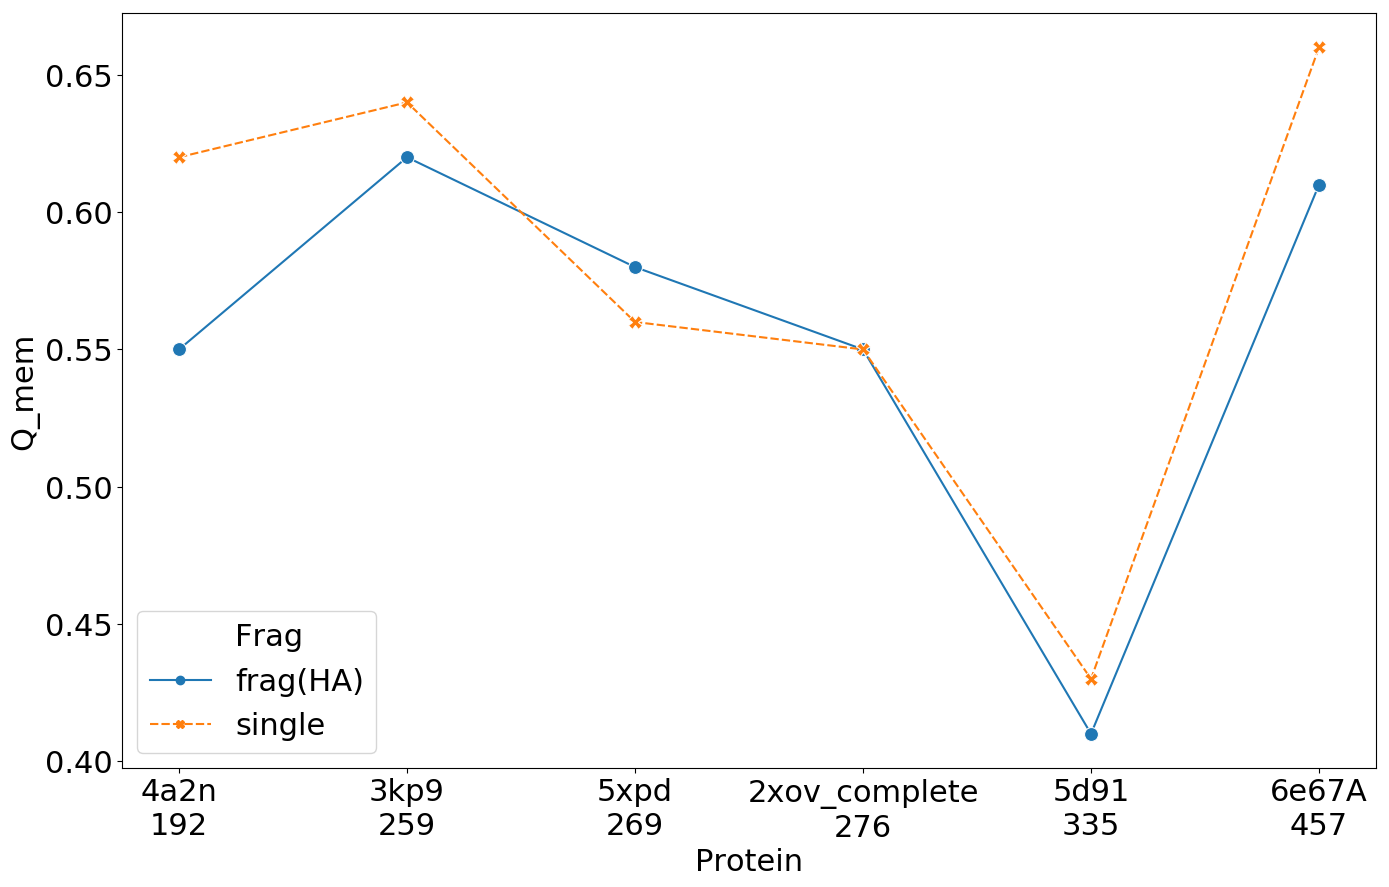

In [24]:
y = "Q_mem"
d = combined.query("Steps > 200").reset_index(drop=True)
d.Protein = pd.Categorical(d.Protein, 
                      categories=pdb_list)
# max_Q_data = d.groupby(["Protein", "Frag"])["Q_wat"].max().reset_index()

t = d.groupby(["Protein", "Frag"])[y].idxmax().reset_index()
max_Q_data = d.iloc[t[y].to_list()].reset_index(drop=True)

ax = sns.lineplot(x="Protein", y=y, hue="Frag", style="Frag", markers=True, ms=10, data=max_Q_data)
_ = ax.set_xticklabels(labels=label_list[1:], rotation=0, ha='center')



In [ ]:
simulationType = "simluation_hybrid"
# folder = "original"
folder = "fifth_with_er"
all_data = []
for pdb in pdb_list:
    for i in range(2):
        for restart in range(1):
            location = f"/Users/weilu/Research/server/jun_2019/{simulationType}/{folder}/{pdb}/{i}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Restart=restart)
                all_data.append(tmp)
            except:
                print(pdb, i, restart)
                pass
data = pd.concat(all_data)
today = datetime.today().strftime('%m-%d')
data.reset_index(drop=True).to_csv(f"/Users/weilu/Research/data/openMM/{simulationType}_{folder}_{today}_er.csv")


In [ ]:
plt.rcParams.update({'font.size': 12})
native_energy = combined.query("Steps < 1 and Run == 0").reset_index(drop=True)
y_show = "Fragment"
g = sns.FacetGrid(combined.query("Steps > 100"), col="Protein",col_wrap=2,  hue="Frag", sharey=False, sharex=False)
g = (g.map(plt.scatter, "Q_wat", y_show, alpha=0.5).add_legend())
# energy = native_energy.query("Name == 'T0759-D1' and Folder == 'multi_iter0_with_minimization'")["VTotal"][0]
# g.axes[0].axhline(energy, ls="--", color="blue", linewidth=4)
# energy = native_energy.query("Name == 'T0759-D1' and Folder == 'original_with_minimization'")["VTotal"][0]
# g.axes[0].axhline(energy, ls="--", color="orange", linewidth=4)
for ax in g.axes:
    name= ax.title.get_text().split(" ")[-1]
    # print(name)
    energy = native_energy.query(f"Protein == '{name}'")[y_show].iloc[0]
    ax.axhline(energy, ls="--", color="blue", linewidth=4)
    try:
        energy = native_energy.query(f"Protein == '{name}'")[y_show].iloc[1]
        ax.axhline(energy, ls="--", color="orange", linewidth=4)
    except:
        pass

In [25]:
pdb_list = ["2xov_complete", "6e67A", "5xpd", "3kp9", "4a2n", "5d91", "2jo1"]

In [223]:
pre = "/Users/weilu/Research/server/jun_2019/simluation_hybrid"
for pdb in pdb_list:
    location = f"{pre}/setup/{pdb}/{pdb}.pdb"
    table = get_inside_or_not_table(location)
    probFile = f"{pre}/TM_pred/{pdb}_PureTM/{pdb}.prob"
    predict_table = get_inside_or_not_table_from_TM_pred(probFile)
    cm = confusion_matrix(table, predict_table)
    print(f"{pdb:^20s}", "{:^10s}".format("pred_0"), "{:^10s}".format("pred_1"))
    print("{:^20s}".format("true_0"), f"{cm[0][0]:^10d}", f"{cm[0][1]:^10d}")
    print("{:^20s}".format("true_1"), f"{cm[1][0]:^10d}", f"{cm[1][1]:^10d}")
    print("")

   2xov_complete       pred_0     pred_1  
       true_0           128         1     
       true_1            40        107    

       6e67A           pred_0     pred_1  
       true_0           292         7     
       true_1            18        140    

        5xpd           pred_0     pred_1  
       true_0           114         10    
       true_1            18        127    

        3kp9           pred_0     pred_1  
       true_0           147         2     
       true_1            17         93    

        4a2n           pred_0     pred_1  
       true_0            80         3     
       true_1            25         84    

        5d91           pred_0     pred_1  
       true_0           183         30    
       true_1            31         91    

        2jo1           pred_0     pred_1  
       true_0            51         1     
       true_1            2          18    



In [31]:
def get_inside_or_not_table_from_TM_pred(probFile):
    with open(f"{probFile}") as f:
            a = f.readlines()
    res_list = []
    for i, line in enumerate(a[3:]):
        prob = float(line.strip().split()[3])
        res = 0 if prob < 0.5 else 1
        res_list.append(res)
    return res_list

In [224]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "4pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

In [170]:
from sklearn.metrics import confusion_matrix

In [172]:
cm = confusion_matrix(table, predict_table)

In [183]:
t = pd.DataFrame(cm, columns=["pred_0", "pred_1"], index=["true_0", "true_1"])

In [221]:
print(f"{pdb:^20s}", "{:^10s}".format("pred_0"), "{:^10s}".format("pred_1"))
print("{:^20s}".format("true_0"), f"{cm[0][0]:^10d}", f"{cm[0][1]:^10d}")
print("{:^20s}".format("true_1"), f"{cm[1][0]:^10d}", f"{cm[1][1]:^10d}")

   2xov_complete       pred_0     pred_1  
       true_0           128         1     
       true_1            40        107    


In [227]:
pdb = pdb_list[0]
print(pdb)
location = f"{pre}/setup/{pdb}/{pdb}.pdb"
table = get_inside_or_not_table(location)
probFile = f"{pre}/TM_pred/{pdb}_PureTM/{pdb}.prob"
predict_table = get_inside_or_not_table_from_TM_pred(probFile)
d = pd.DataFrame([table, predict_table])
bigdf = d

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
a = bigdf.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '10px', 'font-size': '0pt'})\
    .set_precision(2)\
    .set_table_styles(magnify())
a


2xov_complete


In [232]:
pdb = pdb_list[1]
print(pdb)
location = f"{pre}/setup/{pdb}/{pdb}.pdb"
table = get_inside_or_not_table(location)
probFile = f"{pre}/TM_pred/{pdb}_PureTM/{pdb}.prob"
predict_table = get_inside_or_not_table_from_TM_pred(probFile)
d = pd.DataFrame([table, predict_table])
bigdf = d

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
a = bigdf.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '10px', 'font-size': '0pt'})\
    .set_precision(2)\
    .set_table_styles(magnify())
a


6e67A


In [233]:
pdb = pdb_list[2]
print(pdb)
location = f"{pre}/setup/{pdb}/{pdb}.pdb"
table = get_inside_or_not_table(location)
probFile = f"{pre}/TM_pred/{pdb}_PureTM/{pdb}.prob"
predict_table = get_inside_or_not_table_from_TM_pred(probFile)
d = pd.DataFrame([table, predict_table])
bigdf = d

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
a = bigdf.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '10px', 'font-size': '0pt'})\
    .set_precision(2)\
    .set_table_styles(magnify())
a


5xpd


In [234]:
pdb = pdb_list[3]
print(pdb)
location = f"{pre}/setup/{pdb}/{pdb}.pdb"
table = get_inside_or_not_table(location)
probFile = f"{pre}/TM_pred/{pdb}_PureTM/{pdb}.prob"
predict_table = get_inside_or_not_table_from_TM_pred(probFile)
d = pd.DataFrame([table, predict_table])
bigdf = d

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
a = bigdf.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '10px', 'font-size': '0pt'})\
    .set_precision(2)\
    .set_table_styles(magnify())
a


3kp9


In [235]:
pdb = pdb_list[4]
print(pdb)
location = f"{pre}/setup/{pdb}/{pdb}.pdb"
table = get_inside_or_not_table(location)
probFile = f"{pre}/TM_pred/{pdb}_PureTM/{pdb}.prob"
predict_table = get_inside_or_not_table_from_TM_pred(probFile)
d = pd.DataFrame([table, predict_table])
bigdf = d

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
a = bigdf.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '10px', 'font-size': '0pt'})\
    .set_precision(2)\
    .set_table_styles(magnify())
a


4a2n


In [236]:
pdb = pdb_list[5]
print(pdb)
location = f"{pre}/setup/{pdb}/{pdb}.pdb"
table = get_inside_or_not_table(location)
probFile = f"{pre}/TM_pred/{pdb}_PureTM/{pdb}.prob"
predict_table = get_inside_or_not_table_from_TM_pred(probFile)
d = pd.DataFrame([table, predict_table])
bigdf = d

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
a = bigdf.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '10px', 'font-size': '0pt'})\
    .set_precision(2)\
    .set_table_styles(magnify())
a


5d91


In [146]:

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

bigdf.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '10px', 'font-size': '0pt'})\
    .set_precision(2)\
    .set_table_styles(magnify())

In [145]:
# import imgkit
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
bigdf = d
styled_table = bigdf.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '0pt'})\
    .set_precision(2)\
    .set_table_styles(magnify())
with open ('/Users/weilu/Desktop/out.html','w') as out:
    html = styled_table.render()
    out.write(html)

In [165]:
for i in table:
    print(i, end="")
print("")
for i in predict_table:
    print(i, end="")

000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111111010011011111000001111111111111111111111111111111111100001111111111111111111110000011111111111111111100000000001111111111111111111111111111111111111111111000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111111111000000000000000000000000011111111111111111111111000000000111111111111111100000000011111111111111111000000000011111111111111111110000000000111111111111111000000000

In [162]:
d

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  \
0  0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0    
1  0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   0   0    

   21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
0  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    
1  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    

   40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  \
0  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    
1  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    

   59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  \
0  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    
1  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    

   78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  \
0  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1   1   1   1    
1  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1    

   97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  \
0  1   1   1   1    1    1    1    1    1    1    1    1    1    1    1     
1  1   1   1   1    1    1    1    1    1    1    1    1    1    1    1     

   112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  \
0  1    1    0    1    0    0    1    1    0    1    1    1    1    1    0     
1  1    1    0    0    0    0    0    0    0    0    0    0    0    0    0     

   127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  \
0  0    0    0    0    1    1    1    1    1    1    1    1    1    1    1     
1  0    0    0    0    0    0    0    0    0    0    0    0    1    1    1     

   142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  \
0  1    1    1    1    1    1    1    1    1    1    1    1    1    1    1     
1  1    1    1    1    1    1    1    1    1    1    1    1    1    1    1     

   157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  \
0  1    1    1    1    1    1    1    1    1    0    0    0    0    1    1     
1  1    1    1    1    1    0    0    0    0    0    0    0    0    0    1     

   172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  \
0  1    1    1    1    1    1    1    1    1    1    1    1    1    1    1     
1  1    1    1    1    1    1    1    1    1    1    1    1    1    1    1     

   187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  \
0  1    1    1    1    0    0    0    0    0    1    1    1    1    1    1     
1  0    0    0    0    0    0    0    0    0    1    1    1    1    1    1     

   202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  \
0  1    1    1    1    1    1    1    1    1    1    1    1    0    0    0     
1  1    1    1    1    1    1    1    1    1    1    1    0    0    0    0     

   217  218  219  220  221  222  223  224  225  226  227  228  229  230  231  \
0  0    0    0    0    0    0    0    1    1    1    1    1    1    1    1     
1  0    0    0    0    0    0    1    1    1    1    1    1    1    1    1     

   232  233  234  235  236  237  238  239  240  241  242  243  244  245  246  \
0  1    1    1    1    1    1    1    1    1    1    1    1    1    1    1     
1  1    1    1    1    1    1    1    1    1    1    0    0    0    0    0     

   247  248  249  250  251  252  253  254  255  256  257  258  259  260  261  \
0  1    1    1    1    1    1    1    1    1    1    1    1    1    1    1     
1  0    0    0    0    0    1    1    1    1    1    1    1    1    1    1     

   262  263  264  265  266  267  268  269  270  271  272  273  274  275  
0  1    1    1    1    1    0    0    0    0    0    0    0    0    0    

In [104]:
d.columns = [""] * 72

In [102]:
s.hide_columns([0,1])

In [85]:
d

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  \
0  0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   1   1   1   1   1   1    
1  0  0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   1   1   1   1    

   21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  \
0  1   1   1   1   1   1   1   1   1   1   1   1   1   1   0   0   0   0   0    
1  1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   0   0   0   0    

   40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  \
0  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    
1  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0    

   59  60  61  62  63  64  65  66  67  68  69  70  71  
0  0   0   0   0   0   0   0   0   0   0   0   0   0   
1  0   0   0   0   0   0   0   0   0   0   0   0   0

In [76]:
pd.get_option("display.max_rows")

60

In [77]:
pd.get_option("display.max_columns")

2

In [49]:

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val == 1 else 'black'
    return 'color: %s' % color

In [37]:
print().values)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [39]:
print(table)
print(predict_table)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [335]:
pdb = "4rws"
pre = "/Users/weilu/Research/server/jul_2019/hybrid_simulation
loc = f"{pre}/TM_pred/{pdb}_topo"
with open(loc) as f:
    a = f.readlines()
assert len(a) % 3 == 0
chain_count = len(a) // 3
seq = ""
for i in range(chain_count):
    seq_i = (a[i*3+2]).strip()
    seq += seq_i
assert np.alltrue([i in ["0", "1"] for i in seq])
with open(f"{pre}/TM_pred/{pdb}_predicted_zim", "w") as out:
    for i in seq:
        if i == "0":
            out.write("1\n")
        elif i == "1":
            out.write("2\n")
        else:
            raise
    

In [339]:
force_setup_file = f"{pre}/energy_forces/forces_setup_{pdb}.py"
res_list = []
first = None
count = 1
previousEnd = 0
# print("g_all = [")
zimOut = open(f"{pre}/{pdb}_predicted_zim", "w")
out = "[\n"
for i, res in enumerate(seq):
    o = "2" if res == "1" else "1"
    zimOut.write(o+"\n")
    if res == "0":
        if len(res_list) > 0:
            # print(f"g{count} =", res_list)
            print(res_list, ", ")
            out += f"    {res_list},\n"
            count += 1
            last = res_list[-1]
            first = res_list[0] if first is None else first
            span = res_list[0] - previousEnd
            if span > 30:
                print(f"{pdb} Globular", previousEnd, res_list[0])
                globular = list(range(previousEnd+10, res_list[0]-10))
            previousEnd = last
        res_list = []
    if res == "1":
        res_list.append(i)
n = len(seq)
print(f"{pdb}: size {n}")
span = n - previousEnd
if span > 30:
    print(f"{pdb} Globular", previousEnd, n)
    globular = list(range(previousEnd+10, n-10))

out += "]\n"
zimOut.close()
do(f"cp {pre}/TM_pred/{pdb}_predicted_zim {pred}/setup/{pdb}/PredictedZim")

membranePart = []
for i in range(first-5, last+5):
    if i not in globular:
        membranePart.append(i)
# print("]")
# replace(, "GALL", out)
# , backup='.bak'
# print(out, first, last, membranePart, globular)
with fileinput.FileInput(force_setup_file, inplace=True) as file:
    for line in file:
        tmp = line.replace("GALL", out).replace("FIRST", str(first)).replace("LAST", str(last))
        tmp = tmp.replace("RESMEMB", f"{membranePart}")
        tmp = tmp.replace("RESGLOBULAR", f"{globular}")
        print(tmp, end='')

[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41] , 
[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73] , 
[85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109] , 
[127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145] , 
[170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196] , 
[214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237] , 
[257, 258, 259, 260, 261, 262, 263, 264, 265, 266] , 
4rws: size 346
4rws Globular 266 346


In [ ]:
def get_best_frame_and_extract(pdb, run, step, Q="Q_wat"):
    outLocation = f"/Users/weilu/Research/server/jun_2019/simluation_hybrid/sixth_with_er/{Q}_max/{pdb}_best.pdb"
    frame = step - 2
    movieLocation = f'/Users/weilu/Research/server/jun_2019/simluation_hybrid/sixth_with_er/{pdb}/{run}/movie.pdb'
    getFrame(frame, outLocation, movieLocation)
    probFile= f"/Users/weilu/Research/server/jun_2019/simluation_hybrid/TM_pred/{pdb}_PureTM/{pdb}.prob"
    GlobularPart, MembranePart = get_two_part_from_prediction(probFile)
    if pdb == "2xov_complete":
        GlobularPart = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]

    fileLocation = outLocation.split(".")[0]
    parser = PDBParser()
    structure = parser.get_structure('X', outLocation)
    extractResidues(structure, f"{fileLocation}_globular.pdb", GlobularPart)
    extractResidues(structure, f"{fileLocation}_membrane.pdb", MembranePart)


In [ ]:
def get_inside_or_not_table(pdb_file):
    parser = PDBParser(PERMISSIVE=1,QUIET=True)
    try:
        structure = parser.get_structure('X', pdb_file)
    except:
        return [0]
    inside_or_not_table = []
    for res in structure.get_residues():
        if res.get_id()[0] != " ":
            continue  # skip
        try:
            res["CA"].get_vector()
        except:
            print(pdb_file, res.get_id())
            return [0]
        inside_or_not_table.append(int(abs(res["CA"].get_vector()[-1]) < 15))
    return inside_or_not_table

In [ ]:
parser = PDBParser(QUIET=1)
structure = parser.get_structure('X', pdb)